# Development: Donor's Next Gift Prediction

* https://github.com/majerus/apra_data_science_courses/tree/master?tab=readme-ov-file
* Goal: Using donor biographical information and giving history, predict the Month that their next gift will occur.
    * For feasibility, will first test whether the model can predict whether or not the donor will make a gift in the next year.
* Data: 3 tables; Donor Biographical Information, Gift Information, Engagement Information
    * Donor Bio Features: ID, Name, Household ID, Country, City, Birthdate, Deceased, ZIP, State, Latitude, Longitude, Capacity, Capacity Source, Race
    * Gift Info Features: Household ID, ID, Gift ID, Credit Type, Gift Amount, Gift Date
    * Engagement Info Features: ID, Last Contact, Number of Contacts, Gift Officer, Event, Volunteer, Time on Site, Interests
* Classification problem using Machine Learning algorithms like Decision Trees, Logistic Regression, Random Forest, and SVM.
    * Predicting Month of next gift: Multiclass Supervised Classification
    * Predicting if donate next year: Binary Supervised Classification

# Development Dataset Preprocessing

Preprocessing of the three tables: bio_data_table.csv, giving_data_table.csv, and engagement_data_table.csv. Final result will be the dataset used to train, test, and validate the machine learning model.

This notebook will include:
* Cleaning the data: dealing with NULL values, incorrect values
* Feature Engineering

For purposes of this project, 'Today' = 1/1/2020
* Everything prior to 1/1/2020 is considered the past
* 2020 data is considered the future

In [1]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [198]:
#loading the datasets
donor=pd.read_csv('bio_data_table.csv')
giving=pd.read_csv('giving_data_table.csv')
engagement=pd.read_csv('engagement_data_table.csv')

#Shape of each table
print(donor.shape)
print(giving.shape)
print(engagement.shape)

(100000, 14)
(378001, 6)
(100000, 8)


### Donor Table Data Cleanup
Rough clean up of table in preparation for combining with other two tables

In [199]:
#checking first 5 rows of Donor table
donor.head()

id                    name  household_id        country     city  \
0  1581317       Patterson, Aeneas       4310723  United States   Agawam   
1  9952781             Page, Casie       9248960  United States   Agawam   
2  6170220          Vasquez, James       9248960  United States   Agawam   
3  2012013         Garcia, Dezmenn       4731003  United States  Amherst   
4  1021063  Riefstahl, Christopher       6094904  United States  Amherst   

     birthday deceased     zip state    lat    lon      capacity  \
0  1900-01-01        N  1001.0    MA  42.06 -72.61          >$1k   
1  1958-10-20        N  1001.0    MA  42.06 -72.61  $75k - $100k   
2  1958-03-10        N  1001.0    MA  42.06 -72.61  $75k - $100k   
3  1940-07-20        Y  1002.0    MA  42.37 -72.52  $75k - $100k   
4  1982-07-24        N  1002.0    MA  42.37 -72.52  $75k - $100k   

  capacity_source                race  
0       screening  Non-Hispanic white  
1       screening  Non-Hispanic white  
2       screening  Non-Hispanic white  
3             NaN  Non-Hispanic white  
4   institutional  Non-Hispanic white

In [200]:
#checking feature types
donor.dtypes

id                   int64
name                object
household_id         int64
country             object
city                object
birthday            object
deceased            object
zip                float64
state               object
lat                float64
lon                float64
capacity            object
capacity_source     object
race                object
dtype: object

In [201]:
#changing birthday feature type to date
donor['birthday']=pd.to_datetime(donor['birthday'])
donor['birthday'].dtype

dtype('<M8[ns]')

In [202]:
#more information regarding Donor table
donor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               100000 non-null  int64         
 1   name             100000 non-null  object        
 2   household_id     100000 non-null  int64         
 3   country          100000 non-null  object        
 4   city             100000 non-null  object        
 5   birthday         90000 non-null   datetime64[ns]
 6   deceased         90000 non-null   object        
 7   zip              90000 non-null   float64       
 8   state            90000 non-null   object        
 9   lat              90000 non-null   float64       
 10  lon              90000 non-null   float64       
 11  capacity         90000 non-null   object        
 12  capacity_source  90000 non-null   object        
 13  race             100000 non-null  object        
dtypes: datetime64[ns](1),

In [203]:
#fixing ZIP codes
donor['zip']=donor['zip'].apply(lambda x: f'{int(x):05d}' if pd.notnull(x) else x)

#checking first few rows for change
donor.head()

id                    name  household_id        country     city  \
0  1581317       Patterson, Aeneas       4310723  United States   Agawam   
1  9952781             Page, Casie       9248960  United States   Agawam   
2  6170220          Vasquez, James       9248960  United States   Agawam   
3  2012013         Garcia, Dezmenn       4731003  United States  Amherst   
4  1021063  Riefstahl, Christopher       6094904  United States  Amherst   

    birthday deceased    zip state    lat    lon      capacity  \
0 1900-01-01        N  01001    MA  42.06 -72.61          >$1k   
1 1958-10-20        N  01001    MA  42.06 -72.61  $75k - $100k   
2 1958-03-10        N  01001    MA  42.06 -72.61  $75k - $100k   
3 1940-07-20        Y  01002    MA  42.37 -72.52  $75k - $100k   
4 1982-07-24        N  01002    MA  42.37 -72.52  $75k - $100k   

  capacity_source                race  
0       screening  Non-Hispanic white  
1       screening  Non-Hispanic white  
2       screening  Non-Hispanic white  
3             NaN  Non-Hispanic white  
4   institutional  Non-Hispanic white

In [204]:
#chatgpt
from dateutil.relativedelta import relativedelta

today=pd.to_datetime('2020-1-1')

#function to calculate age
def age(birthday):
    return relativedelta(today,birthday).years

#New column: Age
donor['Age']=donor['birthday'].apply(lambda x: age(x) if pd.notnull(x) else x)
donor.head() #checking new column

id                    name  household_id        country     city  \
0  1581317       Patterson, Aeneas       4310723  United States   Agawam   
1  9952781             Page, Casie       9248960  United States   Agawam   
2  6170220          Vasquez, James       9248960  United States   Agawam   
3  2012013         Garcia, Dezmenn       4731003  United States  Amherst   
4  1021063  Riefstahl, Christopher       6094904  United States  Amherst   

    birthday deceased    zip state    lat    lon      capacity  \
0 1900-01-01        N  01001    MA  42.06 -72.61          >$1k   
1 1958-10-20        N  01001    MA  42.06 -72.61  $75k - $100k   
2 1958-03-10        N  01001    MA  42.06 -72.61  $75k - $100k   
3 1940-07-20        Y  01002    MA  42.37 -72.52  $75k - $100k   
4 1982-07-24        N  01002    MA  42.37 -72.52  $75k - $100k   

  capacity_source                race  Age  
0       screening  Non-Hispanic white  120  
1       screening  Non-Hispanic white   61  
2       screening  Non-Hispanic white   61  
3             NaN  Non-Hispanic white   79  
4   institutional  Non-Hispanic white   37

In [205]:
#change 'Age' column to integer
donor['Age']=pd.to_numeric(donor['Age'], errors='coerce').astype('Int64')
donor['Age'].dtypes

Int64Dtype()

In [206]:
#Feature Engineering: Birthday Month
donor['Birthday Month']=donor['birthday'].dt.month
donor.head()

id                    name  household_id        country     city  \
0  1581317       Patterson, Aeneas       4310723  United States   Agawam   
1  9952781             Page, Casie       9248960  United States   Agawam   
2  6170220          Vasquez, James       9248960  United States   Agawam   
3  2012013         Garcia, Dezmenn       4731003  United States  Amherst   
4  1021063  Riefstahl, Christopher       6094904  United States  Amherst   

    birthday deceased    zip state    lat    lon      capacity  \
0 1900-01-01        N  01001    MA  42.06 -72.61          >$1k   
1 1958-10-20        N  01001    MA  42.06 -72.61  $75k - $100k   
2 1958-03-10        N  01001    MA  42.06 -72.61  $75k - $100k   
3 1940-07-20        Y  01002    MA  42.37 -72.52  $75k - $100k   
4 1982-07-24        N  01002    MA  42.37 -72.52  $75k - $100k   

  capacity_source                race  Age  Birthday Month  
0       screening  Non-Hispanic white  120             1.0  
1       screening  Non-Hispanic white   61            10.0  
2       screening  Non-Hispanic white   61             3.0  
3             NaN  Non-Hispanic white   79             7.0  
4   institutional  Non-Hispanic white   37             7.0

In [207]:
#Summary of numerical columns of Donor table
donor.describe()

id  household_id                    birthday           lat  \
count  1.000000e+05  1.000000e+05                       90000  90000.000000   
mean   5.504808e+06  5.520820e+06  1965-09-29 13:23:14.880000     37.649065   
min    1.000065e+06  1.000399e+06         1900-01-01 00:00:00     19.540000   
25%    3.264957e+06  3.291076e+06         1953-12-13 18:00:00     33.920000   
50%    5.501357e+06  5.532263e+06         1965-06-01 00:00:00     38.790000   
75%    7.746170e+06  7.746223e+06         1980-01-28 00:00:00     41.330000   
max    9.999979e+06  9.999973e+06         2003-04-05 00:00:00     64.900000   
std    2.593475e+06  2.587095e+06                         NaN      5.203071   

                lon        Age  Birthday Month  
count  90000.000000    90000.0    90000.000000  
mean     -91.455561  53.762156        6.473689  
min     -159.520000       16.0        1.000000  
25%      -97.740000       39.0        3.000000  
50%      -86.510000       54.0        7.000000  
75%      -79.630000       66.0        9.000000  
max      -67.110000      120.0       12.000000  
std       16.390225  19.166084        3.478486

### Giving Table Data Cleanup
Rough clean up of table in preparation for combining with other two tables

In [208]:
#checking first 5 rows of Giving table
giving.head()

household ID       ID  gift id  credit Type  gift amt   gift date
0       9662153  8494401  2916764  Soft-Credit       385  2016-10-21
1       2484641  5186919  2916801  Hard-Credit       401  2016-10-21
2       2484641  5929757  2916801  Soft-Credit       401  2016-10-21
3       6982155  7005004  2916813  Hard-Credit       420  2016-10-21
4       6982155  3789171  2916813  Soft-Credit       420  2016-10-21

In [209]:
#Giving table feature types + NULL values
giving.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378001 entries, 0 to 378000
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   household ID  378001 non-null  int64 
 1   ID            378001 non-null  int64 
 2   gift id       378001 non-null  int64 
 3   credit Type   378001 non-null  object
 4   gift amt      378001 non-null  int64 
 5   gift date     378001 non-null  object
dtypes: int64(4), object(2)
memory usage: 17.3+ MB


In [210]:
#fixing 'gift date' type
giving['gift date']=pd.to_datetime(giving['gift date'])

In [211]:
#Summary of numerical columns of Giving Table
giving.describe()

household ID            ID       gift id      gift amt  \
count  3.780010e+05  3.780010e+05  3.780010e+05  3.780010e+05   
mean   5.509499e+06  5.507269e+06  6.459635e+06  2.339653e+04   
min    1.000399e+06  1.000065e+06  2.916764e+06  1.000000e+00   
25%    3.272270e+06  3.255782e+06  4.685898e+06  4.590000e+02   
50%    5.503194e+06  5.506108e+06  6.463612e+06  1.053000e+03   
75%    7.736940e+06  7.754071e+06  8.232541e+06  2.560000e+03   
max    9.999973e+06  9.999979e+06  9.999963e+06  9.901063e+06   
std    2.587945e+06  2.595144e+06  2.043465e+06  1.341687e+05   

                           gift date  
count                         378001  
mean   2018-10-07 16:45:36.297522944  
min              2016-10-21 00:00:00  
25%              2017-10-14 00:00:00  
50%              2018-10-07 00:00:00  
75%              2019-09-30 00:00:00  
max              2020-09-25 00:00:00  
std                              NaN

In [212]:
#Feature Engineering: Gift Month
giving['Gift Month']=giving['gift date'].dt.month
giving['Gift Month']

0         10
1         10
2         10
3         10
4         10
          ..
377996     9
377997     9
377998     9
377999     9
378000     9
Name: Gift Month, Length: 378001, dtype: int32

In [213]:
#splitting giving into past/future
past_giving=giving[giving['gift date']< pd.to_datetime('2020-01-01')]
future_giving=giving[giving['gift date']>= pd.to_datetime('2020-01-01')]

In [214]:
#Summary of numerical columns of Past Giving Table
past_giving.describe()

household ID            ID       gift id      gift amt  \
count  3.074550e+05  3.074550e+05  3.074550e+05  3.074550e+05   
mean   5.505707e+06  5.507215e+06  5.799189e+06  2.310104e+04   
min    1.000399e+06  1.000065e+06  2.916764e+06  1.000000e+00   
25%    3.272259e+06  3.256984e+06  4.357992e+06  4.590000e+02   
50%    5.495679e+06  5.505463e+06  5.804480e+06  1.053000e+03   
75%    7.727893e+06  7.754753e+06  7.238404e+06  2.613500e+03   
max    9.999973e+06  9.999979e+06  8.678394e+06  9.744658e+06   
std    2.587045e+06  2.594769e+06  1.662307e+06  1.287758e+05   

                           gift date     Gift Month  
count                         307455  307455.000000  
mean   2018-05-26 16:09:38.894472192       6.803461  
min              2016-10-21 00:00:00       1.000000  
25%              2017-08-09 00:00:00       4.000000  
50%              2018-05-27 00:00:00       7.000000  
75%              2019-03-13 00:00:00      10.000000  
max              2019-12-31 00:00:00      12.000000  
std                              NaN       3.537507

In [215]:
#Summary of numerical columns of Past Giving Table
future_giving.describe()

household ID            ID       gift id      gift amt  \
count  7.054600e+04  7.054600e+04  7.054600e+04  7.054600e+04   
mean   5.526024e+06  5.507507e+06  9.338005e+06  2.468431e+04   
min    1.000399e+06  1.000448e+06  8.678479e+06  1.000000e+00   
25%    3.275264e+06  3.250012e+06  9.005583e+06  4.590000e+02   
50%    5.545571e+06  5.511893e+06  9.336532e+06  1.055000e+03   
75%    7.785493e+06  7.749555e+06  9.668292e+06  2.418000e+03   
max    9.999973e+06  9.999735e+06  9.999963e+06  9.901063e+06   
std    2.591817e+06  2.596798e+06  3.816283e+05  1.554977e+05   

                           gift date    Gift Month  
count                          70546  70546.000000  
mean   2020-05-13 19:24:28.556686592      4.927508  
min              2020-01-01 00:00:00      1.000000  
25%              2020-03-09 00:00:00      3.000000  
50%              2020-05-14 00:00:00      5.000000  
75%              2020-07-19 00:00:00      7.000000  
max              2020-09-25 00:00:00      9.000000  
std                              NaN      2.527432

In [216]:
#Looking at constituents aggregated giving information, split by Hard vs. Soft Credit
ind_giving=past_giving.groupby(['ID','credit Type'])
ind_giving['gift amt'].describe()

count           mean            std      min       25%  \
ID      credit Type                                                           
1000065 Soft-Credit    2.0    3072.500000    4094.855370    177.0   1624.75   
1000448 Hard-Credit    2.0   12578.500000   14960.258170   2000.0   7289.25   
1000493 Hard-Credit    4.0     955.250000     930.589553     22.0    255.25   
1000575 Hard-Credit    1.0    1653.000000            NaN   1653.0   1653.00   
1000737 Soft-Credit    2.0   27709.000000   36109.114888   2176.0  14942.50   
...                    ...            ...            ...      ...       ...   
9999473 Soft-Credit    3.0  116771.333333  143787.917007  11086.0  34902.00   
9999486 Hard-Credit    5.0   61033.000000  134429.255832    339.0    785.00   
9999643 Soft-Credit    2.0    1072.500000    1307.440438    148.0    610.25   
9999735 Hard-Credit    2.0     821.000000     148.492424    716.0    768.50   
9999979 Hard-Credit    4.0     286.000000     303.619279     24.0     93.00   

                         50%        75%       max  
ID      credit Type                                
1000065 Soft-Credit   3072.5    4520.25    5968.0  
1000448 Hard-Credit  12578.5   17867.75   23157.0  
1000493 Hard-Credit    905.5    1605.50    1988.0  
1000575 Hard-Credit   1653.0    1653.00    1653.0  
1000737 Soft-Credit  27709.0   40475.50   53242.0  
...                      ...        ...       ...  
9999473 Soft-Credit  58718.0  169614.00  280510.0  
9999486 Hard-Credit    934.0    1601.00  301506.0  
9999643 Soft-Credit   1072.5    1534.75    1997.0  
9999735 Hard-Credit    821.0     873.50     926.0  
9999979 Hard-Credit    205.5     398.50     709.0  

[78256 rows x 8 columns]

In [217]:
#Feature Engineering: Time between Gifts
past_giving['Time Between']=past_giving.groupby('ID')['gift date'].diff().dt.days
past_giving['Time Between']

/var/folders/rs/56dc52116fdc6_zgn1vcs_fr0000gp/T/ipykernel_8655/2791991256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_giving['Time Between']=past_giving.groupby('ID')['gift date'].diff().dt.days


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
307450    715.0
307451    465.0
307452    465.0
307453    118.0
307454    118.0
Name: Time Between, Length: 307455, dtype: float64

In [218]:
#Feature Engineering: Hard Credit Gifts
past_giving['Hard Credit']=past_giving['credit Type']=='Hard-Credit'
past_giving['Hard Credit']

/var/folders/rs/56dc52116fdc6_zgn1vcs_fr0000gp/T/ipykernel_8655/4077063806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_giving['Hard Credit']=past_giving['credit Type']=='Hard-Credit'


0         False
1          True
2         False
3          True
4         False
          ...  
307450    False
307451     True
307452    False
307453     True
307454    False
Name: Hard Credit, Length: 307455, dtype: bool

In [219]:
#Feature Engineering: Soft Credit Gifts
past_giving['Soft Credit']=past_giving['credit Type']=='Soft-Credit'
past_giving['Soft Credit']

/var/folders/rs/56dc52116fdc6_zgn1vcs_fr0000gp/T/ipykernel_8655/118746406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_giving['Soft Credit']=past_giving['credit Type']=='Soft-Credit'


0          True
1         False
2          True
3         False
4          True
          ...  
307450     True
307451    False
307452     True
307453    False
307454     True
Name: Soft Credit, Length: 307455, dtype: bool

In [220]:
#Aggregating Data by Constituent ID + Feature Engineering
past_giving_agg=past_giving.groupby('ID').agg(
    First_Gift_Date=('gift date','min'),
    Last_Gift_Date=('gift date','max'),
    Median_Time_Between=('Time Between','median'),
    Average_Time_Between=('Time Between','mean'),
    Average_Amount=('gift amt','mean'),
    Number_HardCr=('Hard Credit', 'sum'),
    Number_SoftCr=('Soft Credit','sum'),
    Number_of_Gifts=('gift amt','count')
).reset_index()
past_giving_agg.head()

ID First_Gift_Date Last_Gift_Date  Median_Time_Between  \
0  1000065      2019-03-31     2019-12-25                269.0   
1  1000448      2018-06-16     2018-10-02                108.0   
2  1000493      2017-03-16     2019-08-30                205.0   
3  1000575      2017-10-21     2017-10-21                  NaN   
4  1000737      2017-12-11     2019-06-09                545.0   

   Average_Time_Between  Average_Amount  Number_HardCr  Number_SoftCr  \
0                 269.0         3072.50              0              2   
1                 108.0        12578.50              2              0   
2                 299.0          955.25              4              0   
3                   NaN         1653.00              1              0   
4                 545.0        27709.00              0              2   

   Number_of_Gifts  
0                2  
1                2  
2                4  
3                1  
4                2

In [221]:
#Days since first gift using 'today' to measure
past_giving_agg['Time from First Gift']=(today-past_giving_agg['First_Gift_Date']).dt.days
past_giving_agg['Time from First Gift']

0         276
1         564
2        1021
3         802
4         751
         ... 
78251    1010
78252    1127
78253     752
78254     907
78255    1053
Name: Time from First Gift, Length: 78256, dtype: int64

In [222]:
#Target Variable: Next Gift Month (multiclass classification)
next_gift=future_giving.groupby('ID').agg(Next_Gift_Month=('Gift Month','min')).reset_index()
next_gift

ID  Next_Gift_Month
0      1000448                4
1      1000575                1
2      1000737                6
3      1001062                1
4      1001731                6
...        ...              ...
47113  9999321                4
47114  9999473                7
47115  9999486                7
47116  9999643                1
47117  9999735                1

[47118 rows x 2 columns]

In [223]:
#Target Variable: Give in 2020? (binary classification)
next_gift['Give in 2020?']=next_gift['Next_Gift_Month'].apply(lambda x: 1 if x>0 else 0)
next_gift

ID  Next_Gift_Month  Give in 2020?
0      1000448                4              1
1      1000575                1              1
2      1000737                6              1
3      1001062                1              1
4      1001731                6              1
...        ...              ...            ...
47113  9999321                4              1
47114  9999473                7              1
47115  9999486                7              1
47116  9999643                1              1
47117  9999735                1              1

[47118 rows x 3 columns]

In [224]:
#Merging aggregated Past Giving Table + Target Variables
giving_features=pd.merge(past_giving_agg,next_gift, on='ID', how='left')
giving_features

ID First_Gift_Date Last_Gift_Date  Median_Time_Between  \
0      1000065      2019-03-31     2019-12-25                269.0   
1      1000448      2018-06-16     2018-10-02                108.0   
2      1000493      2017-03-16     2019-08-30                205.0   
3      1000575      2017-10-21     2017-10-21                  NaN   
4      1000737      2017-12-11     2019-06-09                545.0   
...        ...             ...            ...                  ...   
78251  9999473      2017-03-27     2019-06-13                404.0   
78252  9999486      2016-11-30     2019-09-22                136.5   
78253  9999643      2017-12-10     2019-09-30                659.0   
78254  9999735      2017-07-08     2017-08-10                 33.0   
78255  9999979      2017-02-12     2019-03-16                141.0   

       Average_Time_Between  Average_Amount  Number_HardCr  Number_SoftCr  \
0                     269.0     3072.500000              0              2   
1                     108.0    12578.500000              2              0   
2                     299.0      955.250000              4              0   
3                       NaN     1653.000000              1              0   
4                     545.0    27709.000000              0              2   
...                     ...             ...            ...            ...   
78251                 404.0   116771.333333              0              3   
78252                 256.5    61033.000000              5              0   
78253                 659.0     1072.500000              0              2   
78254                  33.0      821.000000              2              0   
78255                 254.0      286.000000              4              0   

       Number_of_Gifts  Time from First Gift  Next_Gift_Month  Give in 2020?  
0                    2                   276              NaN            NaN  
1                    2                   564              4.0            1.0  
2                    4                  1021              NaN            NaN  
3                    1                   802              1.0            1.0  
4                    2                   751              6.0            1.0  
...                ...                   ...              ...            ...  
78251                3                  1010              7.0            1.0  
78252                5                  1127              7.0            1.0  
78253                2                   752              1.0            1.0  
78254                2                   907              1.0            1.0  
78255                4                  1053              NaN            NaN  

[78256 rows x 12 columns]

In [225]:
giving_features.isnull().sum()

ID                          0
First_Gift_Date             0
Last_Gift_Date              0
Median_Time_Between      6596
Average_Time_Between     6596
Average_Amount              0
Number_HardCr               0
Number_SoftCr               0
Number_of_Gifts             0
Time from First Gift        0
Next_Gift_Month         32212
Give in 2020?           32212
dtype: int64

In [226]:
#Dealing with NULL values in features; NULL bc only one gift in dataset, therefore median time and average time should just be time since that single gift
giving_features['Median_Time_Between']=giving_features['Median_Time_Between'].fillna(giving_features['Time from First Gift'])
giving_features['Average_Time_Between']=giving_features['Average_Time_Between'].fillna(giving_features['Time from First Gift'])

#Dealing with NULL values in Target
giving_features['Next_Gift_Month']=giving_features['Next_Gift_Month'].fillna(0)
giving_features['Give in 2020?']=giving_features['Give in 2020?'].fillna('0')

In [227]:
giving_features.isnull().sum()

ID                      0
First_Gift_Date         0
Last_Gift_Date          0
Median_Time_Between     0
Average_Time_Between    0
Average_Amount          0
Number_HardCr           0
Number_SoftCr           0
Number_of_Gifts         0
Time from First Gift    0
Next_Gift_Month         0
Give in 2020?           0
dtype: int64

### Engagement Table Data Cleanup
Rough clean up of table in preparation for combining with other two tables

Not actually going to use because of significant number of NULL values

In [228]:
#checkign first 5 rows of Engagement table
engagement.head()

id last_contact  numer_of_contacts gift_officer event  volunteer  \
0  1581317          NaN                0.0          NaN     Y        NaN   
1  2012013          NaN                8.0          NaN     Y        NaN   
2  1021063          NaN                0.0          NaN     N        NaN   
3  2725629          NaN                NaN          NaN     N        NaN   
4  1880411          NaN                0.0          NaN     N        NaN   

   time_on_site                            interests  
0         432.0  skiing,golf,reading,hunting/fishing  
1           NaN                                  NaN  
2           NaN                      hunting/fishing  
3         119.0                                  NaN  
4           NaN                                  NaN

In [229]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 100000 non-null  int64  
 1   last_contact       63634 non-null   object 
 2   numer_of_contacts  83801 non-null   float64
 3   gift_officer       3589 non-null    object 
 4   event              90002 non-null   object 
 5   volunteer          8969 non-null    float64
 6   time_on_site       20002 non-null   float64
 7   interests          63801 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 6.1+ MB


In [230]:
#change 'last contact' to datetime
engagement['last_contact']=pd.to_datetime(engagement['last_contact'])
engagement.dtypes

id                            int64
last_contact         datetime64[ns]
numer_of_contacts           float64
gift_officer                 object
event                        object
volunteer                   float64
time_on_site                float64
interests                    object
dtype: object

In [231]:
#Feature Engineering: Days since last contact
engagement['Days since last contact']=(today-engagement['last_contact']).dt.days
engagement.dtypes

id                                  int64
last_contact               datetime64[ns]
numer_of_contacts                 float64
gift_officer                       object
event                              object
volunteer                         float64
time_on_site                      float64
interests                          object
Days since last contact           float64
dtype: object

In [232]:
engagement.isnull().sum()

id                             0
last_contact               36366
numer_of_contacts          16199
gift_officer               96411
event                       9998
volunteer                  91031
time_on_site               79998
interests                  36199
Days since last contact    36366
dtype: int64

# Summary Table + Visualization

## Summary Table
* Using Functions to define whether a feature is categorical or numerical (+ datetime)
* This is not accurate, merely makes use of simple logic to roughly assign feature type and give some summary information
    * Unique values, number of unique values (if large number), range, number of NULL values

In [233]:
#Capitalizing 'id' in Donor Table to match 'ID' in Gift Table
donor.rename(columns={'id':'ID'},inplace=True)
donor.head()

ID                    name  household_id        country     city  \
0  1581317       Patterson, Aeneas       4310723  United States   Agawam   
1  9952781             Page, Casie       9248960  United States   Agawam   
2  6170220          Vasquez, James       9248960  United States   Agawam   
3  2012013         Garcia, Dezmenn       4731003  United States  Amherst   
4  1021063  Riefstahl, Christopher       6094904  United States  Amherst   

    birthday deceased    zip state    lat    lon      capacity  \
0 1900-01-01        N  01001    MA  42.06 -72.61          >$1k   
1 1958-10-20        N  01001    MA  42.06 -72.61  $75k - $100k   
2 1958-03-10        N  01001    MA  42.06 -72.61  $75k - $100k   
3 1940-07-20        Y  01002    MA  42.37 -72.52  $75k - $100k   
4 1982-07-24        N  01002    MA  42.37 -72.52  $75k - $100k   

  capacity_source                race  Age  Birthday Month  
0       screening  Non-Hispanic white  120             1.0  
1       screening  Non-Hispanic white   61            10.0  
2       screening  Non-Hispanic white   61             3.0  
3             NaN  Non-Hispanic white   79             7.0  
4   institutional  Non-Hispanic white   37             7.0

In [234]:
#Capitalizing 'id' in Engagement Table to match 'ID' in Gift Table
engagement.rename(columns={'id':'ID'},inplace=True)
engagement.head()

ID last_contact  numer_of_contacts gift_officer event  volunteer  \
0  1581317          NaT                0.0          NaN     Y        NaN   
1  2012013          NaT                8.0          NaN     Y        NaN   
2  1021063          NaT                0.0          NaN     N        NaN   
3  2725629          NaT                NaN          NaN     N        NaN   
4  1880411          NaT                0.0          NaN     N        NaN   

   time_on_site                            interests  Days since last contact  
0         432.0  skiing,golf,reading,hunting/fishing                      NaN  
1           NaN                                  NaN                      NaN  
2           NaN                      hunting/fishing                      NaN  
3         119.0                                  NaN                      NaN  
4           NaN                                  NaN                      NaN

In [235]:
#Combining Donor Bio Table, Engagement Table, and Aggregated Gift Table
df=pd.merge(donor,engagement, on='ID', how='left')
df=pd.merge(df,giving_features, on='ID', how='left')
df.columns

Index(['ID', 'name', 'household_id', 'country', 'city', 'birthday', 'deceased',
       'zip', 'state', 'lat', 'lon', 'capacity', 'capacity_source', 'race',
       'Age', 'Birthday Month', 'last_contact', 'numer_of_contacts',
       'gift_officer', 'event', 'volunteer', 'time_on_site', 'interests',
       'Days since last contact', 'First_Gift_Date', 'Last_Gift_Date',
       'Median_Time_Between', 'Average_Time_Between', 'Average_Amount',
       'Number_HardCr', 'Number_SoftCr', 'Number_of_Gifts',
       'Time from First Gift', 'Next_Gift_Month', 'Give in 2020?'],
      dtype='object')

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   ID                       100000 non-null  int64         
 1   name                     100000 non-null  object        
 2   household_id             100000 non-null  int64         
 3   country                  100000 non-null  object        
 4   city                     100000 non-null  object        
 5   birthday                 90000 non-null   datetime64[ns]
 6   deceased                 90000 non-null   object        
 7   zip                      90000 non-null   object        
 8   state                    90000 non-null   object        
 9   lat                      90000 non-null   float64       
 10  lon                      90000 non-null   float64       
 11  capacity                 90000 non-null   object        
 12  capacity_source  

In [237]:
#summary table; feature categorization (categorical or numerical)

#dropping first 3 columns
df=df.iloc[:,3:]

#empty list to hold descriptor for each feature
feat_cat=[]

#iterating through all columns to categorize them
for col in df.columns:
    #column has object dtype -> categorical feature
    if df[col].dtype==object:
        feat_cat.append('Categorical')
    elif pd.api.types.is_datetime64_any_dtype(df[col]): #chatgpt
        feat_cat.append('Datetime')
    else:
        #if the number of unique values < 5 -> categorical
        if df[col].unique().sum()<5:
            feat_cat.append('Categorical')
        #all other columns must be numerical
        else:
            feat_cat.append('Numerical')

#expecting a list of 22 items
feat_cat

['Categorical',
 'Categorical',
 'Datetime',
 'Categorical',
 'Categorical',
 'Categorical',
 'Numerical',
 'Numerical',
 'Categorical',
 'Categorical',
 'Categorical',
 'Numerical',
 'Numerical',
 'Datetime',
 'Numerical',
 'Categorical',
 'Categorical',
 'Numerical',
 'Numerical',
 'Categorical',
 'Numerical',
 'Datetime',
 'Datetime',
 'Numerical',
 'Numerical',
 'Numerical',
 'Numerical',
 'Numerical',
 'Numerical',
 'Numerical',
 'Numerical',
 'Categorical']

In [238]:
#summary table; values

#empty list to hold values for each feature
vals=[]

#iterating through all columns to get unique values for each
for col in df.columns:
    #column has object dtype -> categorical feature; use .unique() to get values
    if df[col].dtype==object:
        uni_vals=df[col].unique().tolist()
        if len(uni_vals)>5:
            vals.append(f'{len(uni_vals)} unique values')
        else:
            vals.append(uni_vals)
    elif pd.api.types.is_datetime64_any_dtype(df[col]): #chatgpt
        vals.append(f'{df[col].min()} - {df[col].max()}')
    else:
        #if the number of unique values < 5 -> categorical; use .unique() to get values
        if df[col].nunique()<5:
            uni_vals=df[col].unique().tolist()
            vals.append(uni_vals)
        #all other columns must be numerical; get range of values
        else:
            col_range=df[col].max()-df[col].min()
            vals.append(col_range)

#checking values list; whether list of unique values or a range should correspond to cat/num denotation
vals

['10 unique values',
 '7641 unique values',
 '1900-01-01 00:00:00 - 2003-04-05 00:00:00',
 ['N', 'Y', nan],
 '14969 unique values',
 '52 unique values',
 np.float64(45.36000000000001),
 np.float64(92.41000000000001),
 '17 unique values',
 ['screening', nan, 'institutional'],
 '7 unique values',
 np.int64(104),
 np.float64(11.0),
 '2015-09-27 00:00:00 - 2020-09-24 00:00:00',
 np.float64(50.0),
 '21 unique values',
 ['Y', 'N', nan],
 [nan, 0.0, 1.0],
 np.float64(993.0),
 '24576 unique values',
 np.float64(1824.0),
 '2016-10-21 00:00:00 - 2019-12-31 00:00:00',
 '2016-10-21 00:00:00 - 2019-12-31 00:00:00',
 np.float64(1167.0),
 np.float64(1167.0),
 np.float64(3483707.5),
 np.float64(14.0),
 np.float64(14.0),
 np.float64(13.0),
 np.float64(1166.0),
 np.float64(9.0),
 [nan, '0', 1.0]]

In [239]:
#table summary; missing values

#empty list to hold missing values count
na_count=[]

#iterating through all columns to get number of missing values
for col in df.columns:
    na_count.append(df[col].isnull().sum())

#NULL value counts per column
na_count

[np.int64(0),
 np.int64(0),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(0),
 np.int64(10000),
 np.int64(10000),
 np.int64(36366),
 np.int64(16199),
 np.int64(96411),
 np.int64(9998),
 np.int64(91031),
 np.int64(79998),
 np.int64(36199),
 np.int64(36366),
 np.int64(21744),
 np.int64(21744),
 np.int64(21744),
 np.int64(21744),
 np.int64(21744),
 np.int64(21744),
 np.int64(21744),
 np.int64(21744),
 np.int64(21744),
 np.int64(21744),
 np.int64(21744)]

In [240]:
#Features into list for summary table
FeatureNames=[]
for col in df.columns:
    FeatureNames.append(col)
FeatureNames

['country',
 'city',
 'birthday',
 'deceased',
 'zip',
 'state',
 'lat',
 'lon',
 'capacity',
 'capacity_source',
 'race',
 'Age',
 'Birthday Month',
 'last_contact',
 'numer_of_contacts',
 'gift_officer',
 'event',
 'volunteer',
 'time_on_site',
 'interests',
 'Days since last contact',
 'First_Gift_Date',
 'Last_Gift_Date',
 'Median_Time_Between',
 'Average_Time_Between',
 'Average_Amount',
 'Number_HardCr',
 'Number_SoftCr',
 'Number_of_Gifts',
 'Time from First Gift',
 'Next_Gift_Month',
 'Give in 2020?']

In [241]:
#summary table
sumtab={
    'Features':FeatureNames,
    'Column Type':feat_cat,
    'Values/Range':vals,
    'NA Count':na_count,
}

sumtab=pd.DataFrame(sumtab)
sumtab.set_index('Features',inplace=True)
sumtab

Column Type  \
Features                               
country                  Categorical   
city                     Categorical   
birthday                    Datetime   
deceased                 Categorical   
zip                      Categorical   
state                    Categorical   
lat                        Numerical   
lon                        Numerical   
capacity                 Categorical   
capacity_source          Categorical   
race                     Categorical   
Age                        Numerical   
Birthday Month             Numerical   
last_contact                Datetime   
numer_of_contacts          Numerical   
gift_officer             Categorical   
event                    Categorical   
volunteer                  Numerical   
time_on_site               Numerical   
interests                Categorical   
Days since last contact    Numerical   
First_Gift_Date             Datetime   
Last_Gift_Date              Datetime   
Median_Time_Between        Numerical   
Average_Time_Between       Numerical   
Average_Amount             Numerical   
Number_HardCr              Numerical   
Number_SoftCr              Numerical   
Number_of_Gifts            Numerical   
Time from First Gift       Numerical   
Next_Gift_Month            Numerical   
Give in 2020?            Categorical   

                                                      Values/Range  NA Count  
Features                                                                      
country                                           10 unique values         0  
city                                            7641 unique values         0  
birthday                 1900-01-01 00:00:00 - 2003-04-05 00:00:00     10000  
deceased                                               [N, Y, nan]     10000  
zip                                            14969 unique values     10000  
state                                             52 unique values     10000  
lat                                                          45.36     10000  
lon                                                          92.41     10000  
capacity                                          17 unique values     10000  
capacity_source                    [screening, nan, institutional]     10000  
race                                               7 unique values         0  
Age                                                            104     10000  
Birthday Month                                                11.0     10000  
last_contact             2015-09-27 00:00:00 - 2020-09-24 00:00:00     36366  
numer_of_contacts                                             50.0     16199  
gift_officer                                      21 unique values     96411  
event                                                  [Y, N, nan]      9998  
volunteer                                          [nan, 0.0, 1.0]     91031  
time_on_site                                                 993.0     79998  
interests                                      24576 unique values     36199  
Days since last contact                                     1824.0     36366  
First_Gift_Date          2016-10-21 00:00:00 - 2019-12-31 00:00:00     21744  
Last_Gift_Date           2016-10-21 00:00:00 - 2019-12-31 00:00:00     21744  
Median_Time_Between                                         1167.0     21744  
Average_Time_Between                                        1167.0     21744  
Average_Amount                                           3483707.5     21744  
Number_HardCr                                                 14.0     21744  
Number_SoftCr                                                 14.0     21744  
Number_of_Gifts                                               13.0     21744  
Time from First Gift                                        1166.0     21744  
Next_Gift_Month                                                9.0     21744  
Give in 2020?                                        [nan

## Clean up based on what is seen in Summary Table
* 'Give in 2020?' > fill with '0' because if left join created NULL values, it means that constituent never made a donation (gift)
* 'Next_Gift_Month' > fill with '0'; NULL from left join means constituent never made a gift, will use '0' to designate there is no 'Next_Gift_Month'
* 'deceased' > fill with 'N'; in development by default constituents are not marked as deceased, so only those that are verified dead would have this status changed to 'Y'
* 'capacity' > mode
* 'capacity_source' > mode
* 'Age' > median + categorize
* 'Birthday Month' > mode
* Location columns > categorizing one of them to keep (city has no NULL values)
* 'Average Amount', 'Number_HardCr', 'Number_SoftCr', 'Number_of_Gifts' > fill with '0'; NULL from left join means constituent never made a donation so those values should be '0'
* 'Median_Time_Between', 'Average_Time_Betweem', 'Time from First Gift' > number of days using date range of all gifts (from table: 10/21/2016 to 12/31/2019)

In [242]:
#Dealing with the easy NULL values
df['Next_Gift_Month']=df['Next_Gift_Month'].fillna(0)
df['Give in 2020?']=df['Give in 2020?'].fillna(0)
df['deceased']=df['deceased'].fillna('N')
df['Average_Amount']=df['Average_Amount'].fillna(0)
df['Number_HardCr']=df['Number_HardCr'].fillna(0)
df['Number_SoftCr']=df['Number_SoftCr'].fillna(0)
df['Number_of_Gifts']=df['Number_of_Gifts'].fillna(0)
df.isnull().sum()

country                        0
city                           0
birthday                   10000
deceased                       0
zip                        10000
state                      10000
lat                        10000
lon                        10000
capacity                   10000
capacity_source            10000
race                           0
Age                        10000
Birthday Month             10000
last_contact               36366
numer_of_contacts          16199
gift_officer               96411
event                       9998
volunteer                  91031
time_on_site               79998
interests                  36199
Days since last contact    36366
First_Gift_Date            21744
Last_Gift_Date             21744
Median_Time_Between        21744
Average_Time_Between       21744
Average_Amount                 0
Number_HardCr                  0
Number_SoftCr                  0
Number_of_Gifts                0
Time from First Gift       21744
Next_Gift_

In [273]:
df['Give in 2020?']=pd.to_numeric(df['Give in 2020?'])
df['Give in 2020?'].dtypes

dtype('float64')

In [248]:
#calculating days since firsy gift
firstday=pd.to_datetime('2016-10-21')
daterange=(today-firstday).days
daterange

#filling NULL values as discussed above
df['Median_Time_Between']=df['Median_Time_Between'].fillna(daterange)
df['Average_Time_Between']=df['Average_Time_Between'].fillna(daterange)
df['Time from First Gift']=df['Time from First Gift'].fillna(daterange)
df.isnull().sum()

country                        0
city                           0
birthday                   10000
deceased                       0
zip                        10000
state                      10000
lat                        10000
lon                        10000
capacity                   10000
capacity_source            10000
race                           0
Age                        10000
Birthday Month             10000
last_contact               36366
numer_of_contacts          16199
gift_officer               96411
event                       9998
volunteer                  91031
time_on_site               79998
interests                  36199
Days since last contact    36366
First_Gift_Date            21744
Last_Gift_Date             21744
Median_Time_Between            0
Average_Time_Between           0
Average_Amount                 0
Number_HardCr                  0
Number_SoftCr                  0
Number_of_Gifts                0
Time from First Gift           0
Next_Gift_

In [251]:
#filling NULL values with mode
df['capacity']=df['capacity'].fillna(df['capacity'].mode()[0])
df['capacity_source']=df['capacity_source'].fillna(df['capacity_source'].mode()[0])
df.isnull().sum()

country                        0
city                           0
birthday                   10000
deceased                       0
zip                        10000
state                      10000
lat                        10000
lon                        10000
capacity                       0
capacity_source                0
race                           0
Age                        10000
Birthday Month             10000
last_contact               36366
numer_of_contacts          16199
gift_officer               96411
event                       9998
volunteer                  91031
time_on_site               79998
interests                  36199
Days since last contact    36366
First_Gift_Date            21744
Last_Gift_Date             21744
Median_Time_Between            0
Average_Time_Between           0
Average_Amount                 0
Number_HardCr                  0
Number_SoftCr                  0
Number_of_Gifts                0
Time from First Gift           0
Next_Gift_

In [252]:
#Age/Birthday Month
df['Age']=df['Age'].fillna(df['Age'].median())
df['Birthday Month']=df['Birthday Month'].fillna(df['Birthday Month'].mode()[0])
df.isnull().sum()

country                        0
city                           0
birthday                   10000
deceased                       0
zip                        10000
state                      10000
lat                        10000
lon                        10000
capacity                       0
capacity_source                0
race                           0
Age                            0
Birthday Month                 0
last_contact               36366
numer_of_contacts          16199
gift_officer               96411
event                       9998
volunteer                  91031
time_on_site               79998
interests                  36199
Days since last contact    36366
First_Gift_Date            21744
Last_Gift_Date             21744
Median_Time_Between            0
Average_Time_Between           0
Average_Amount                 0
Number_HardCr                  0
Number_SoftCr                  0
Number_of_Gifts                0
Time from First Gift           0
Next_Gift_

## Visualization
* quick glance to see everything before further cleanup
* more targeted visuals

In [317]:
#dataset using Binary Classification
df_binary=df.drop(df.columns[-2],axis=1) #dropping Next Gift Month column
df_binary.head()

country     city   birthday deceased    zip state    lat    lon  \
0  United States   Agawam 1900-01-01        N  01001    MA  42.06 -72.61   
1  United States   Agawam 1958-10-20        N  01001    MA  42.06 -72.61   
2  United States   Agawam 1958-03-10        N  01001    MA  42.06 -72.61   
3  United States  Amherst 1940-07-20        Y  01002    MA  42.37 -72.52   
4  United States  Amherst 1982-07-24        N  01002    MA  42.37 -72.52   

       capacity capacity_source  ... First_Gift_Date  Last_Gift_Date  \
0          >$1k       screening  ...             NaT             NaT   
1  $75k - $100k       screening  ...      2017-08-27      2018-01-06   
2  $75k - $100k       screening  ...      2017-08-27      2018-01-06   
3  $75k - $100k       screening  ...             NaT             NaT   
4  $75k - $100k   institutional  ...             NaT             NaT   

   Median_Time_Between Average_Time_Between  Average_Amount Number_HardCr  \
0               1167.0               1167.0             0.0           0.0   
1                132.0                132.0           974.0           2.0   
2                132.0                132.0           974.0           0.0   
3               1167.0               1167.0             0.0           0.0   
4               1167.0               1167.0             0.0           0.0   

  Number_SoftCr  Number_of_Gifts  Time from First Gift Give in 2020?  
0           0.0              0.0                1167.0           0.0  
1           0.0              2.0                 857.0           0.0  
2           2.0              2.0                 857.0           0.0  
3           0.0              0.0                1167.0           0.0  
4           0.0              0.0                1167.0           0.0  

[5 rows x 31 columns]

In [318]:
#remove repeative location columns, birthday, Engagement columns,first/last gift date
df_binary=df_binary.drop(columns=['birthday','zip','state','lat','lon','last_contact','numer_of_contacts','gift_officer','event','volunteer','time_on_site','interests','Days since last contact','First_Gift_Date','Last_Gift_Date'],axis=1)
df_binary.head()

country     city deceased      capacity capacity_source  \
0  United States   Agawam        N          >$1k       screening   
1  United States   Agawam        N  $75k - $100k       screening   
2  United States   Agawam        N  $75k - $100k       screening   
3  United States  Amherst        Y  $75k - $100k       screening   
4  United States  Amherst        N  $75k - $100k   institutional   

                 race  Age  Birthday Month  Median_Time_Between  \
0  Non-Hispanic white  120             1.0               1167.0   
1  Non-Hispanic white   61            10.0                132.0   
2  Non-Hispanic white   61             3.0                132.0   
3  Non-Hispanic white   79             7.0               1167.0   
4  Non-Hispanic white   37             7.0               1167.0   

   Average_Time_Between  Average_Amount  Number_HardCr  Number_SoftCr  \
0                1167.0             0.0            0.0            0.0   
1                 132.0           974.0            2.0            0.0   
2                 132.0           974.0            0.0            2.0   
3                1167.0             0.0            0.0            0.0   
4                1167.0             0.0            0.0            0.0   

   Number_of_Gifts  Time from First Gift  Give in 2020?  
0              0.0                1167.0            0.0  
1              2.0                 857.0            0.0  
2              2.0                 857.0            0.0  
3              0.0                1167.0            0.0  
4              0.0                1167.0            0.0

In [319]:
df_binary.isnull().sum()

country                 0
city                    0
deceased                0
capacity                0
capacity_source         0
race                    0
Age                     0
Birthday Month          0
Median_Time_Between     0
Average_Time_Between    0
Average_Amount          0
Number_HardCr           0
Number_SoftCr           0
Number_of_Gifts         0
Time from First Gift    0
Give in 2020?           0
dtype: int64

In [320]:
df_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   country               100000 non-null  object 
 1   city                  100000 non-null  object 
 2   deceased              100000 non-null  object 
 3   capacity              100000 non-null  object 
 4   capacity_source       100000 non-null  object 
 5   race                  100000 non-null  object 
 6   Age                   100000 non-null  Int64  
 7   Birthday Month        100000 non-null  float64
 8   Median_Time_Between   100000 non-null  float64
 9   Average_Time_Between  100000 non-null  float64
 10  Average_Amount        100000 non-null  float64
 11  Number_HardCr         100000 non-null  float64
 12  Number_SoftCr         100000 non-null  float64
 13  Number_of_Gifts       100000 non-null  float64
 14  Time from First Gift  100000 non-null  float64
 15  G

In [321]:
df_binary.describe()

Age  Birthday Month  Median_Time_Between  Average_Time_Between  \
count   100000.0   100000.000000        100000.000000         100000.000000   
mean    53.78594        5.926320           456.558985            471.461402   
std    18.182674        3.685974           420.529765            409.153610   
min         16.0        1.000000             0.000000              0.000000   
25%         41.0        2.000000           135.000000            168.600000   
50%         54.0        6.000000           251.000000            266.000000   
75%         64.0        9.000000           806.000000            806.000000   
max        120.0       12.000000          1167.000000           1167.000000   

       Average_Amount  Number_HardCr  Number_SoftCr  Number_of_Gifts  \
count    1.000000e+05  100000.000000  100000.000000    100000.000000   
mean     1.785939e+04       1.537270       1.537280         3.074550   
std      6.023044e+04       2.257725       2.257729         2.338415   
min      0.000000e+00       0.000000       0.000000         0.000000   
25%      3.703750e+02       0.000000       0.000000         1.000000   
50%      1.534900e+03       0.000000       0.000000         3.000000   
75%      1.411912e+04       3.000000       3.000000         5.000000   
max      3.483708e+06      14.000000      14.000000        14.000000   

       Time from First Gift  Give in 2020?  
count         100000.000000  100000.000000  
mean             949.585120       0.460440  
std              247.440885       0.498435  
min                1.000000       0.000000  
25%              834.000000       0.000000  
50%             1034.000000       0.000000  
75%             1155.000000       1.000000  
max             1167.000000       1.000000

In [308]:
#Professor Farbin's pairplot code
#function that iterates through specified columns to create histogram
def compare_distributions(df,column_name,selections,**kwargs): #function allows for additional arguments '**kwargs' so that one can include all options found in 'plt.hist()'
    #looping through each key/value pair from selections
    for label,selection in selections.items(): 
        _=plt.hist(df[selection][column_name],label=label,**kwargs) #plotting histogram of selected feature and column
    
    _=plt.legend() #inclusion of legend

#function that iterates through specified columns to create a scatterplot
def compare_scatter(df,x_var_name,y_var_name,selections,make_legend=True,**kwargs) :
    #looping through each key/value pair from selections
    for label,selection in selections.items():   
        _=plt.scatter(df[selection][x_var_name],df[selection][y_var_name],label=label,**kwargs) #scatterplot of each selection

    _=plt.xlabel(x_var_name) #labeling
    _=plt.ylabel(y_var_name)

    if make_legend:
        _=plt.legend() #inclusion of legend depending on whether 'make_legend' argument is true/false

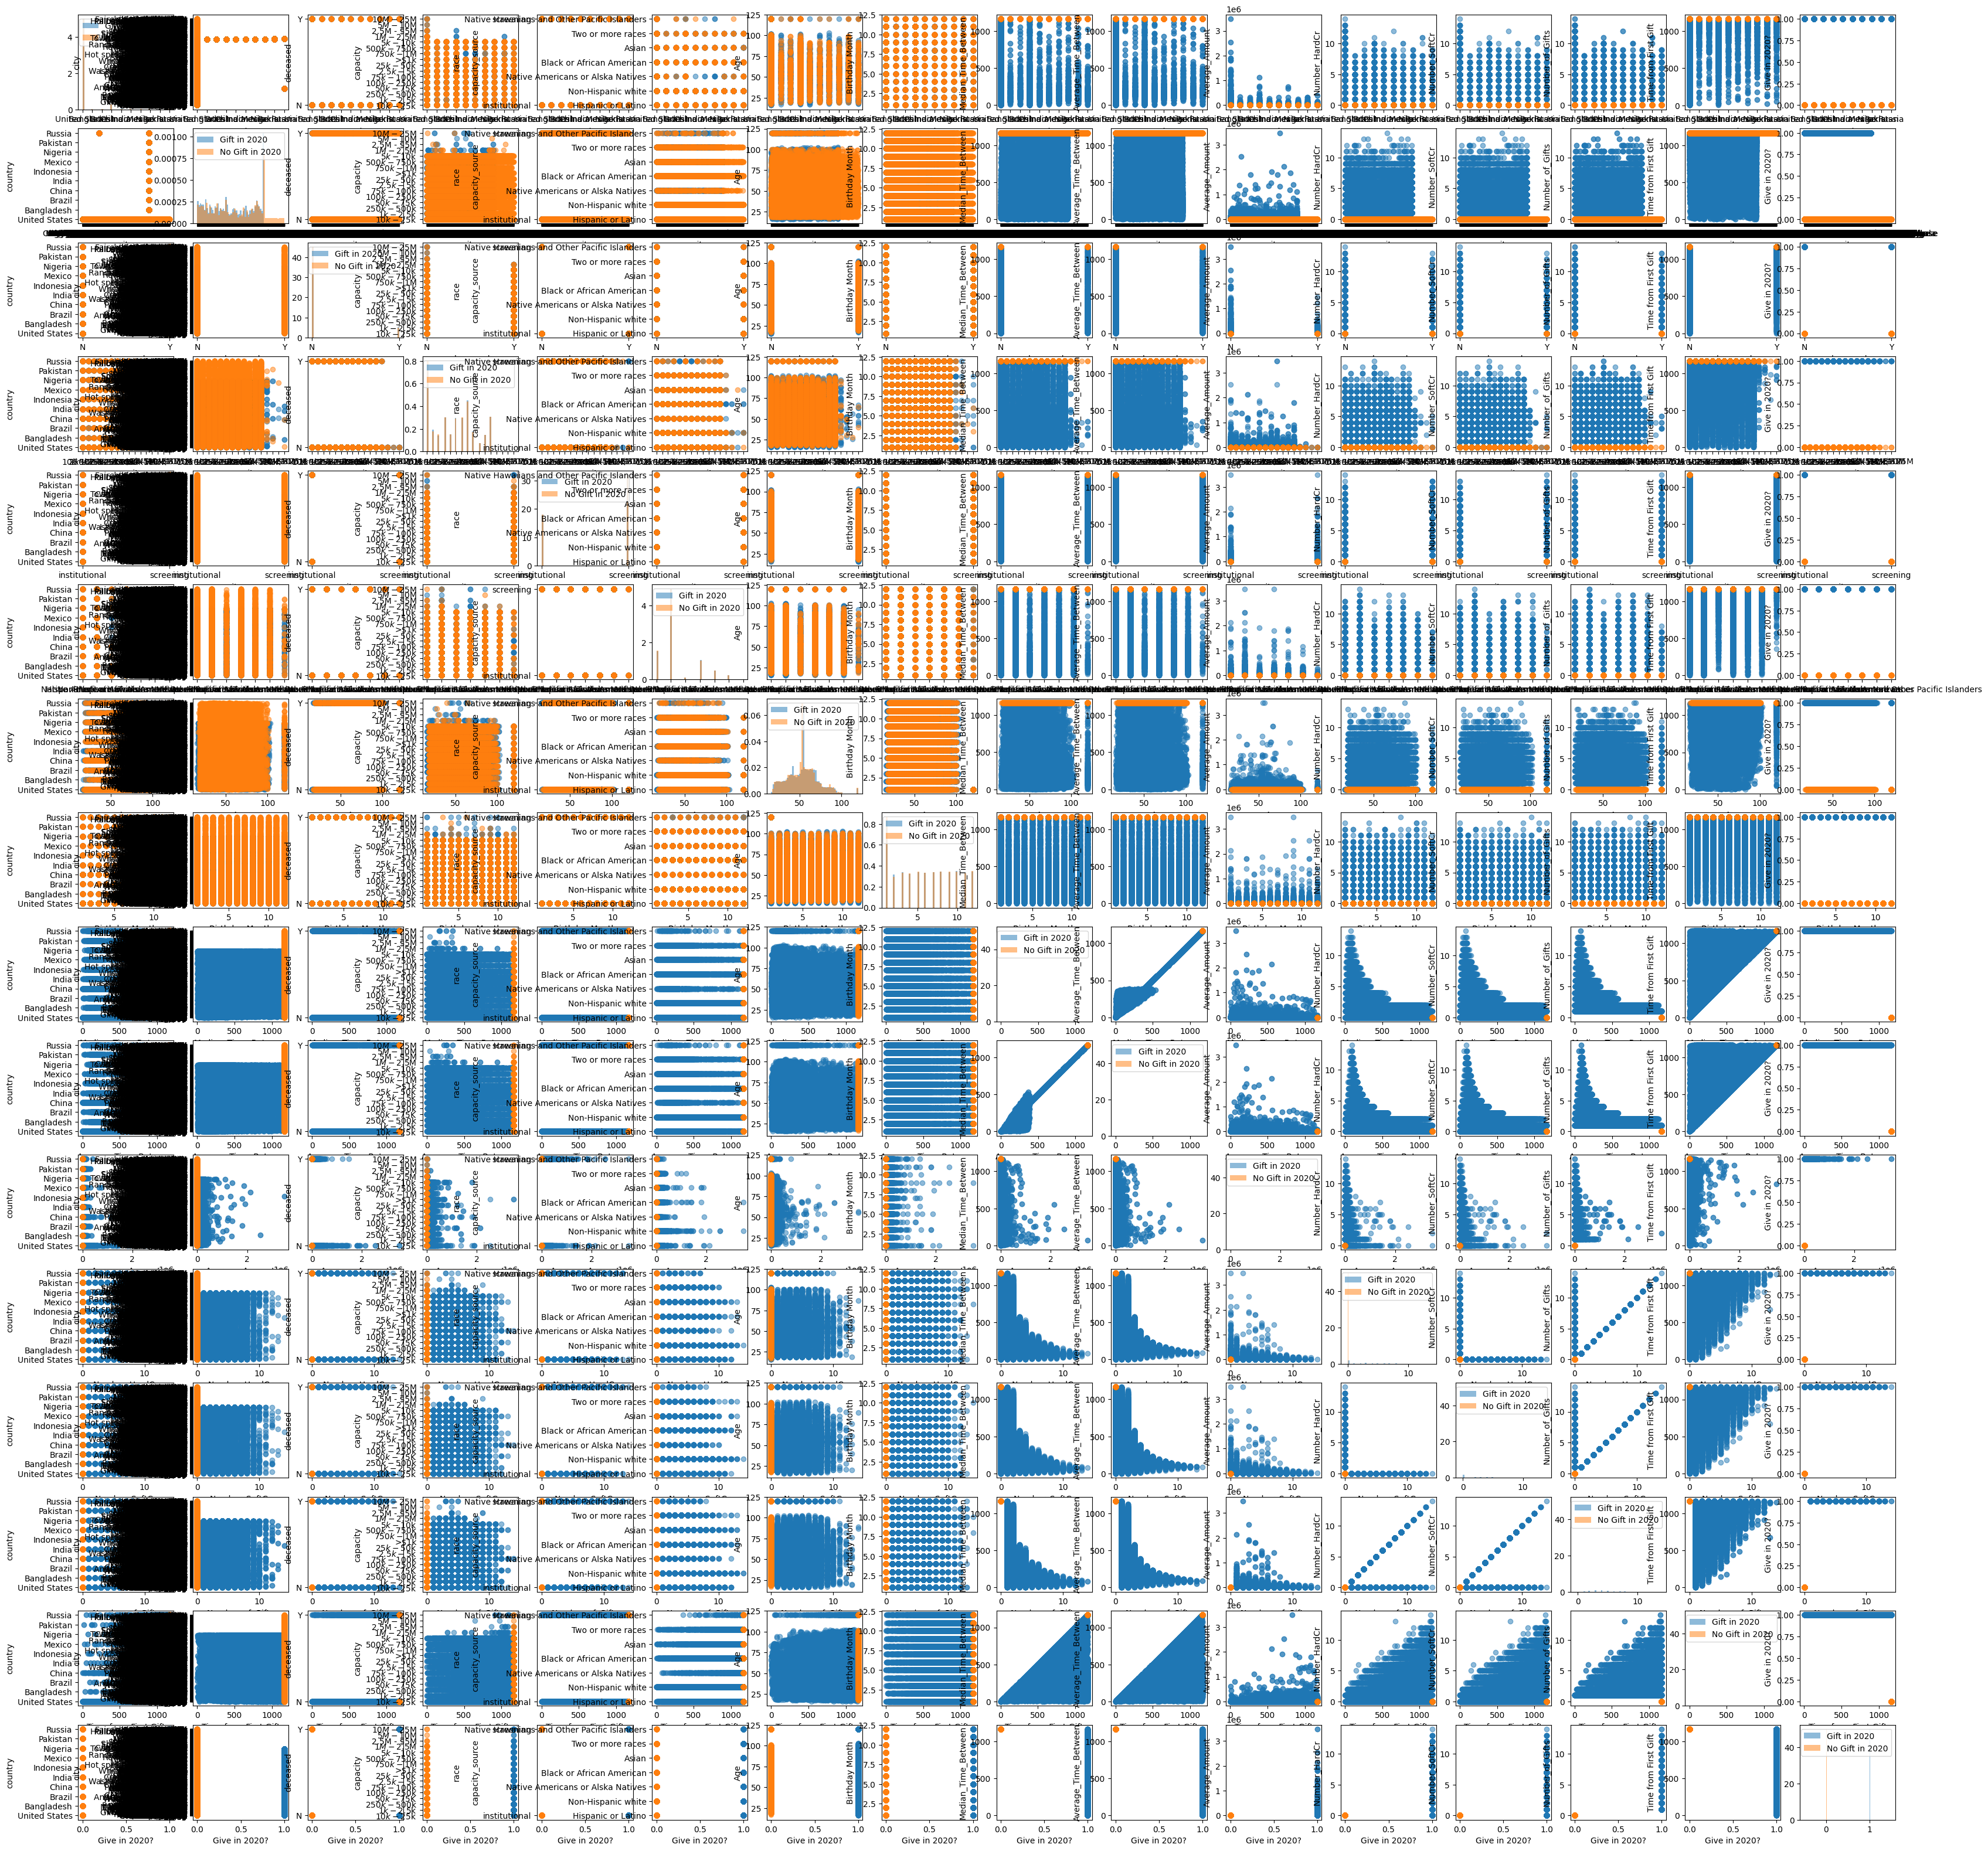

In [259]:
#Professor Farbin's pairplot code
#pair plots
selection_dict={'Gift in 2020':df_binary['Give in 2020?']==1,'No Gift in 2020':df_binary['Give in 2020?']==0} #label/naming and telling that 0/1 means background/signal respectively
column_names=df_binary.columns.to_list()
n_columns=len(column_names)
plt.figure(figsize=(40,40)) #setting up figure size

plot_i=0 #counter to allow for indexing for placement of subplots

#iterating and enumerating through variables
for i,x_var_name in enumerate(column_names):
    #another loop since plotting each variable against each other
    for j,y_var_name in enumerate(column_names):
        plot_i+=1 #increase counter for indexing
        plt.subplot(n_columns,n_columns,plot_i) #subplot layout is the number of features by number of features; 'plot_it' is the index
        make_legend = plot_i==1
        if i==j: #plots on the diagonal
            #plot histogram of feature instead of scatterplot of one feature against itself
            compare_distributions(df_binary,x_var_name,
                     selection_dict,
                     alpha=0.5,
                     density=1,
                     bins=50,
                     )
        else:
            #when not on the diagonal, plot the scatter plot
            compare_scatter(df_binary,x_var_name,y_var_name,selection_dict,make_legend=make_legend,alpha=0.5)


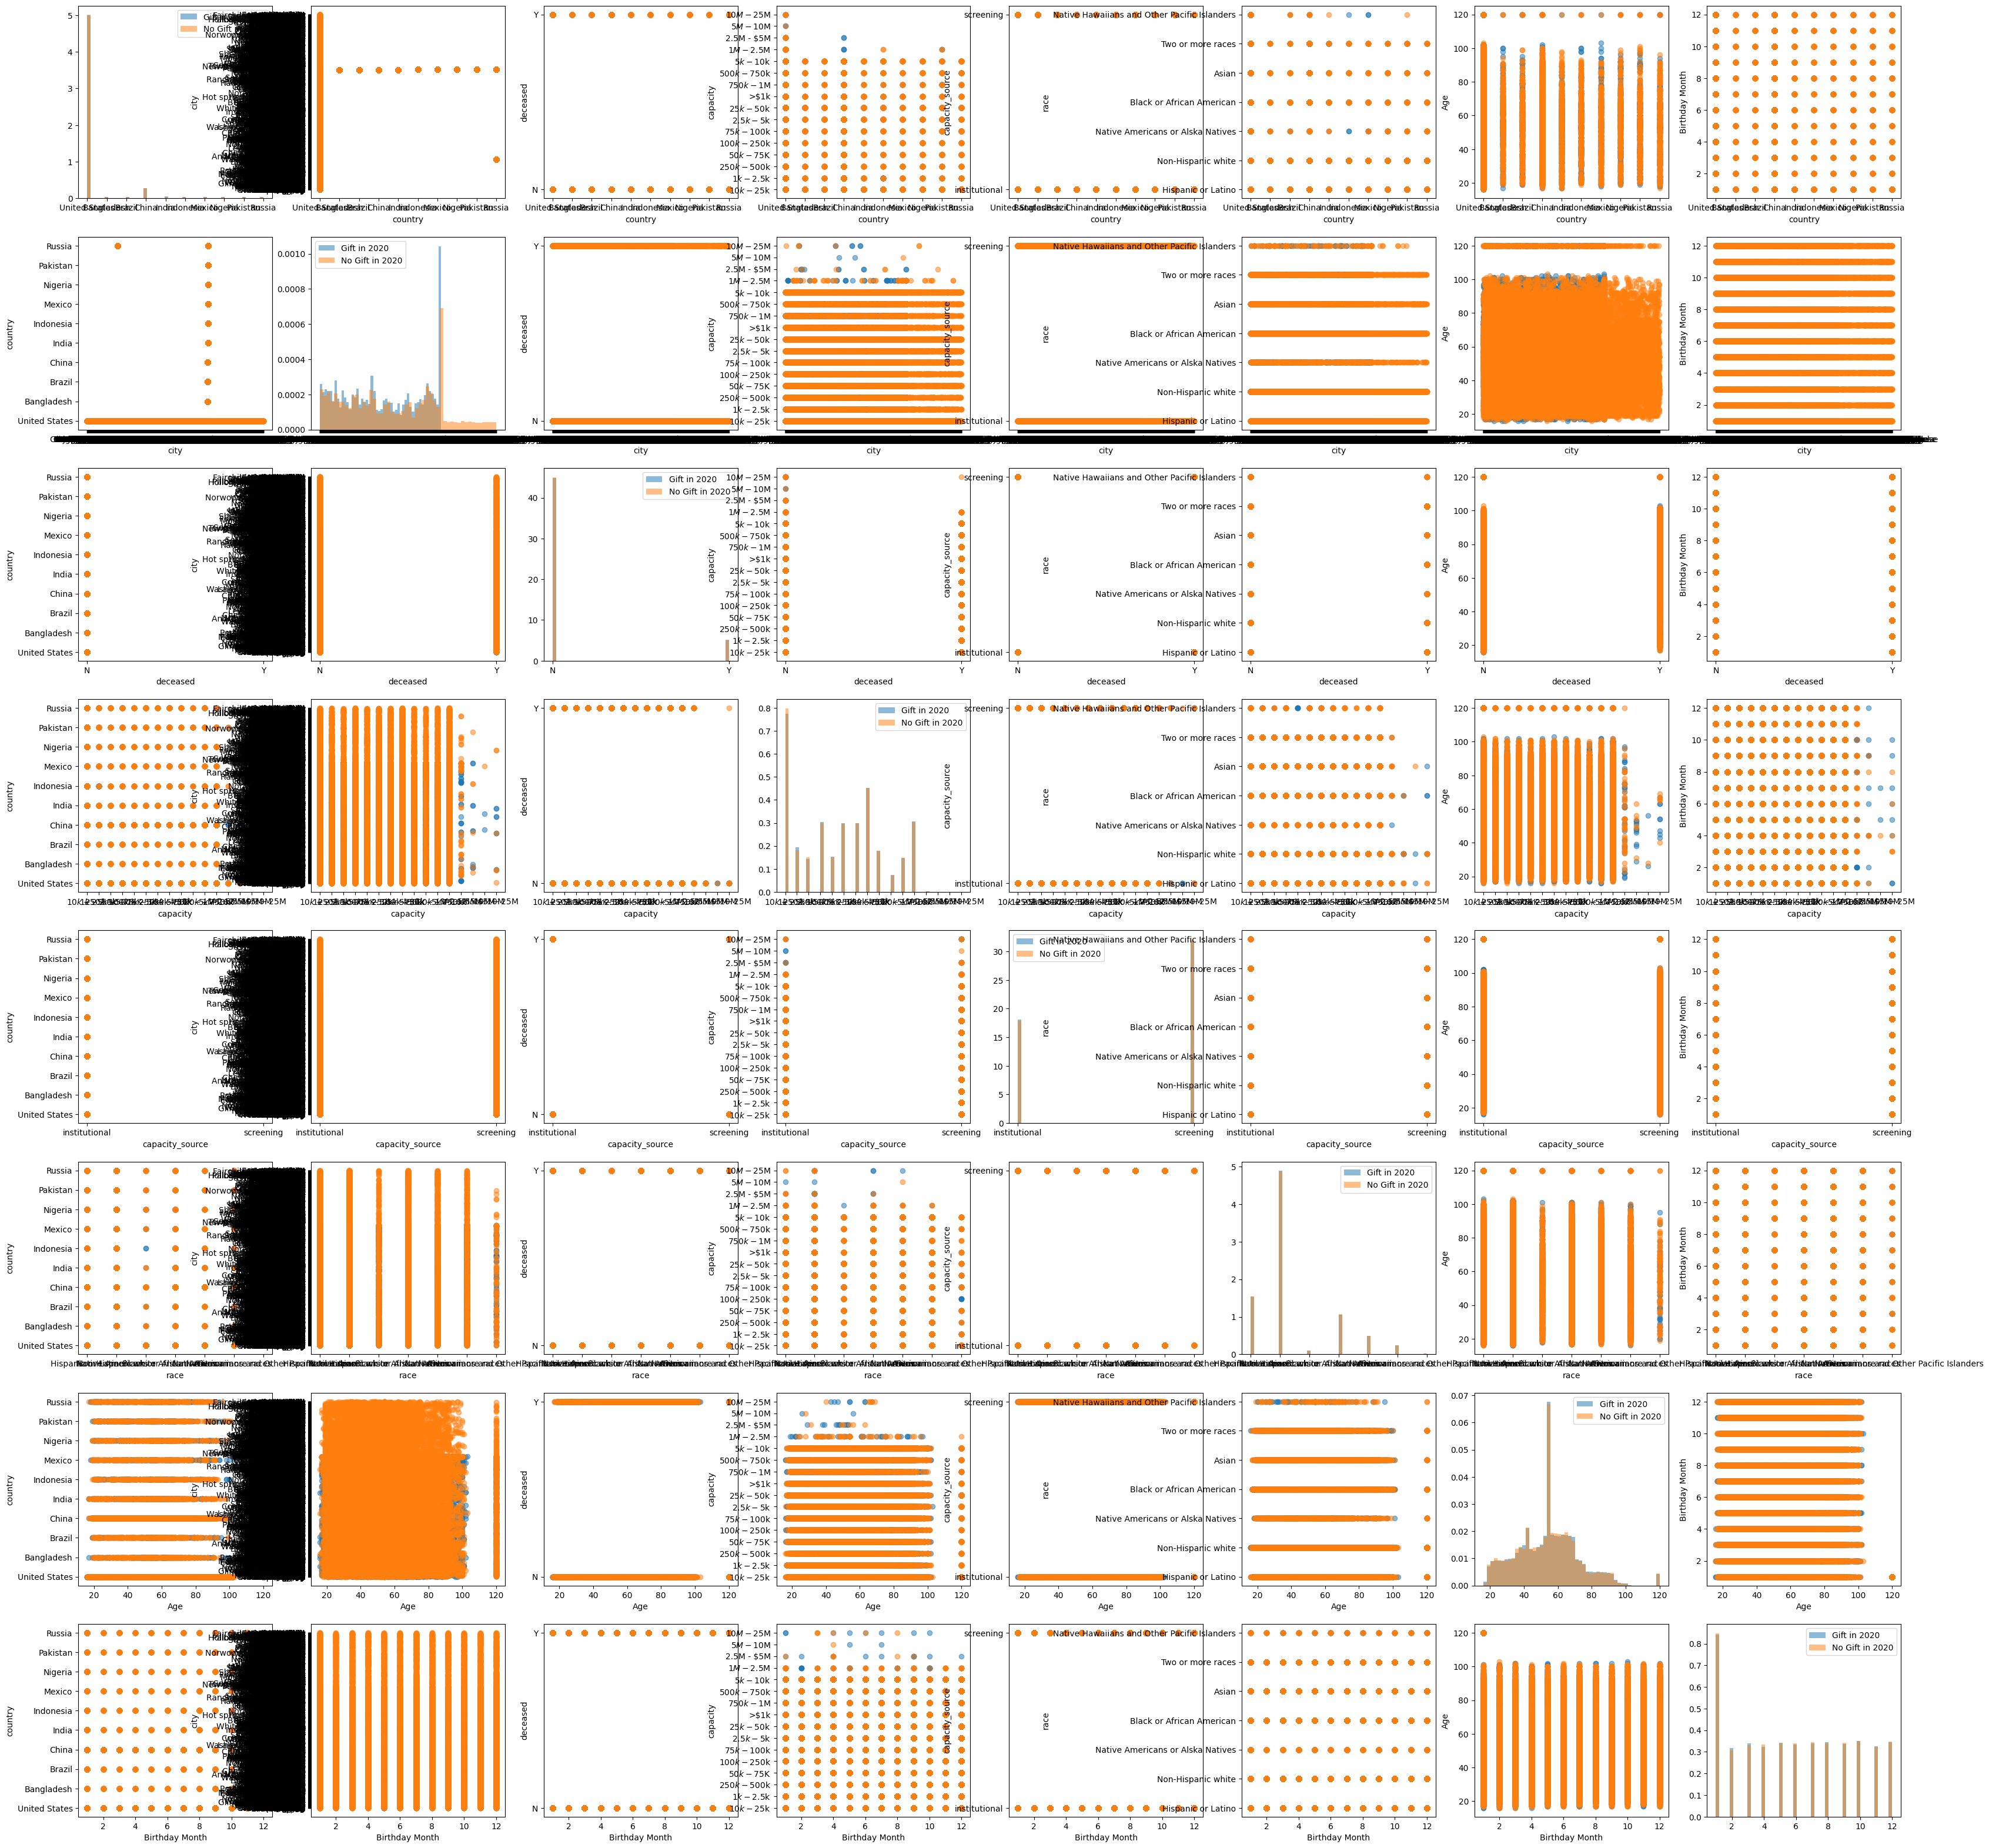

In [279]:
#Just biographical columns
#Professor Farbin's pairplot code
#pair plots
selection_dict={'Gift in 2020':df_binary['Give in 2020?']==1,'No Gift in 2020':df_binary['Give in 2020?']==0} #label/naming and telling that 0/1 means background/signal respectively
column_names=['country','city','deceased','capacity','capacity_source','race','Age','Birthday Month']
n_columns=len(column_names)
plt.figure(figsize=(40,40)) #setting up figure size

plot_i=0 #counter to allow for indexing for placement of subplots

#iterating and enumerating through variables
for i,x_var_name in enumerate(column_names):
    #another loop since plotting each variable against each other
    for j,y_var_name in enumerate(column_names):
        plot_i+=1 #increase counter for indexing
        plt.subplot(n_columns,n_columns,plot_i) #subplot layout is the number of features by number of features; 'plot_it' is the index
        make_legend = plot_i==1
        if i==j: #plots on the diagonal
            #plot histogram of feature instead of scatterplot of one feature against itself
            compare_distributions(df_binary,x_var_name,
                     selection_dict,
                     alpha=0.5,
                     density=1,
                     bins=50,
                     )
        else:
            #when not on the diagonal, plot the scatter plot
            compare_scatter(df_binary,x_var_name,y_var_name,selection_dict,make_legend=make_legend,alpha=0.5)


Notes on Donor Biographical Info Columns
* None of the histograms show promise in distribution difference between those that will Give in 2020 and those that will Not Give in 2020
* All categorical values besides Age
    * Except Age will be turned into categorical to contain outliers (16 years old and 120 years old)


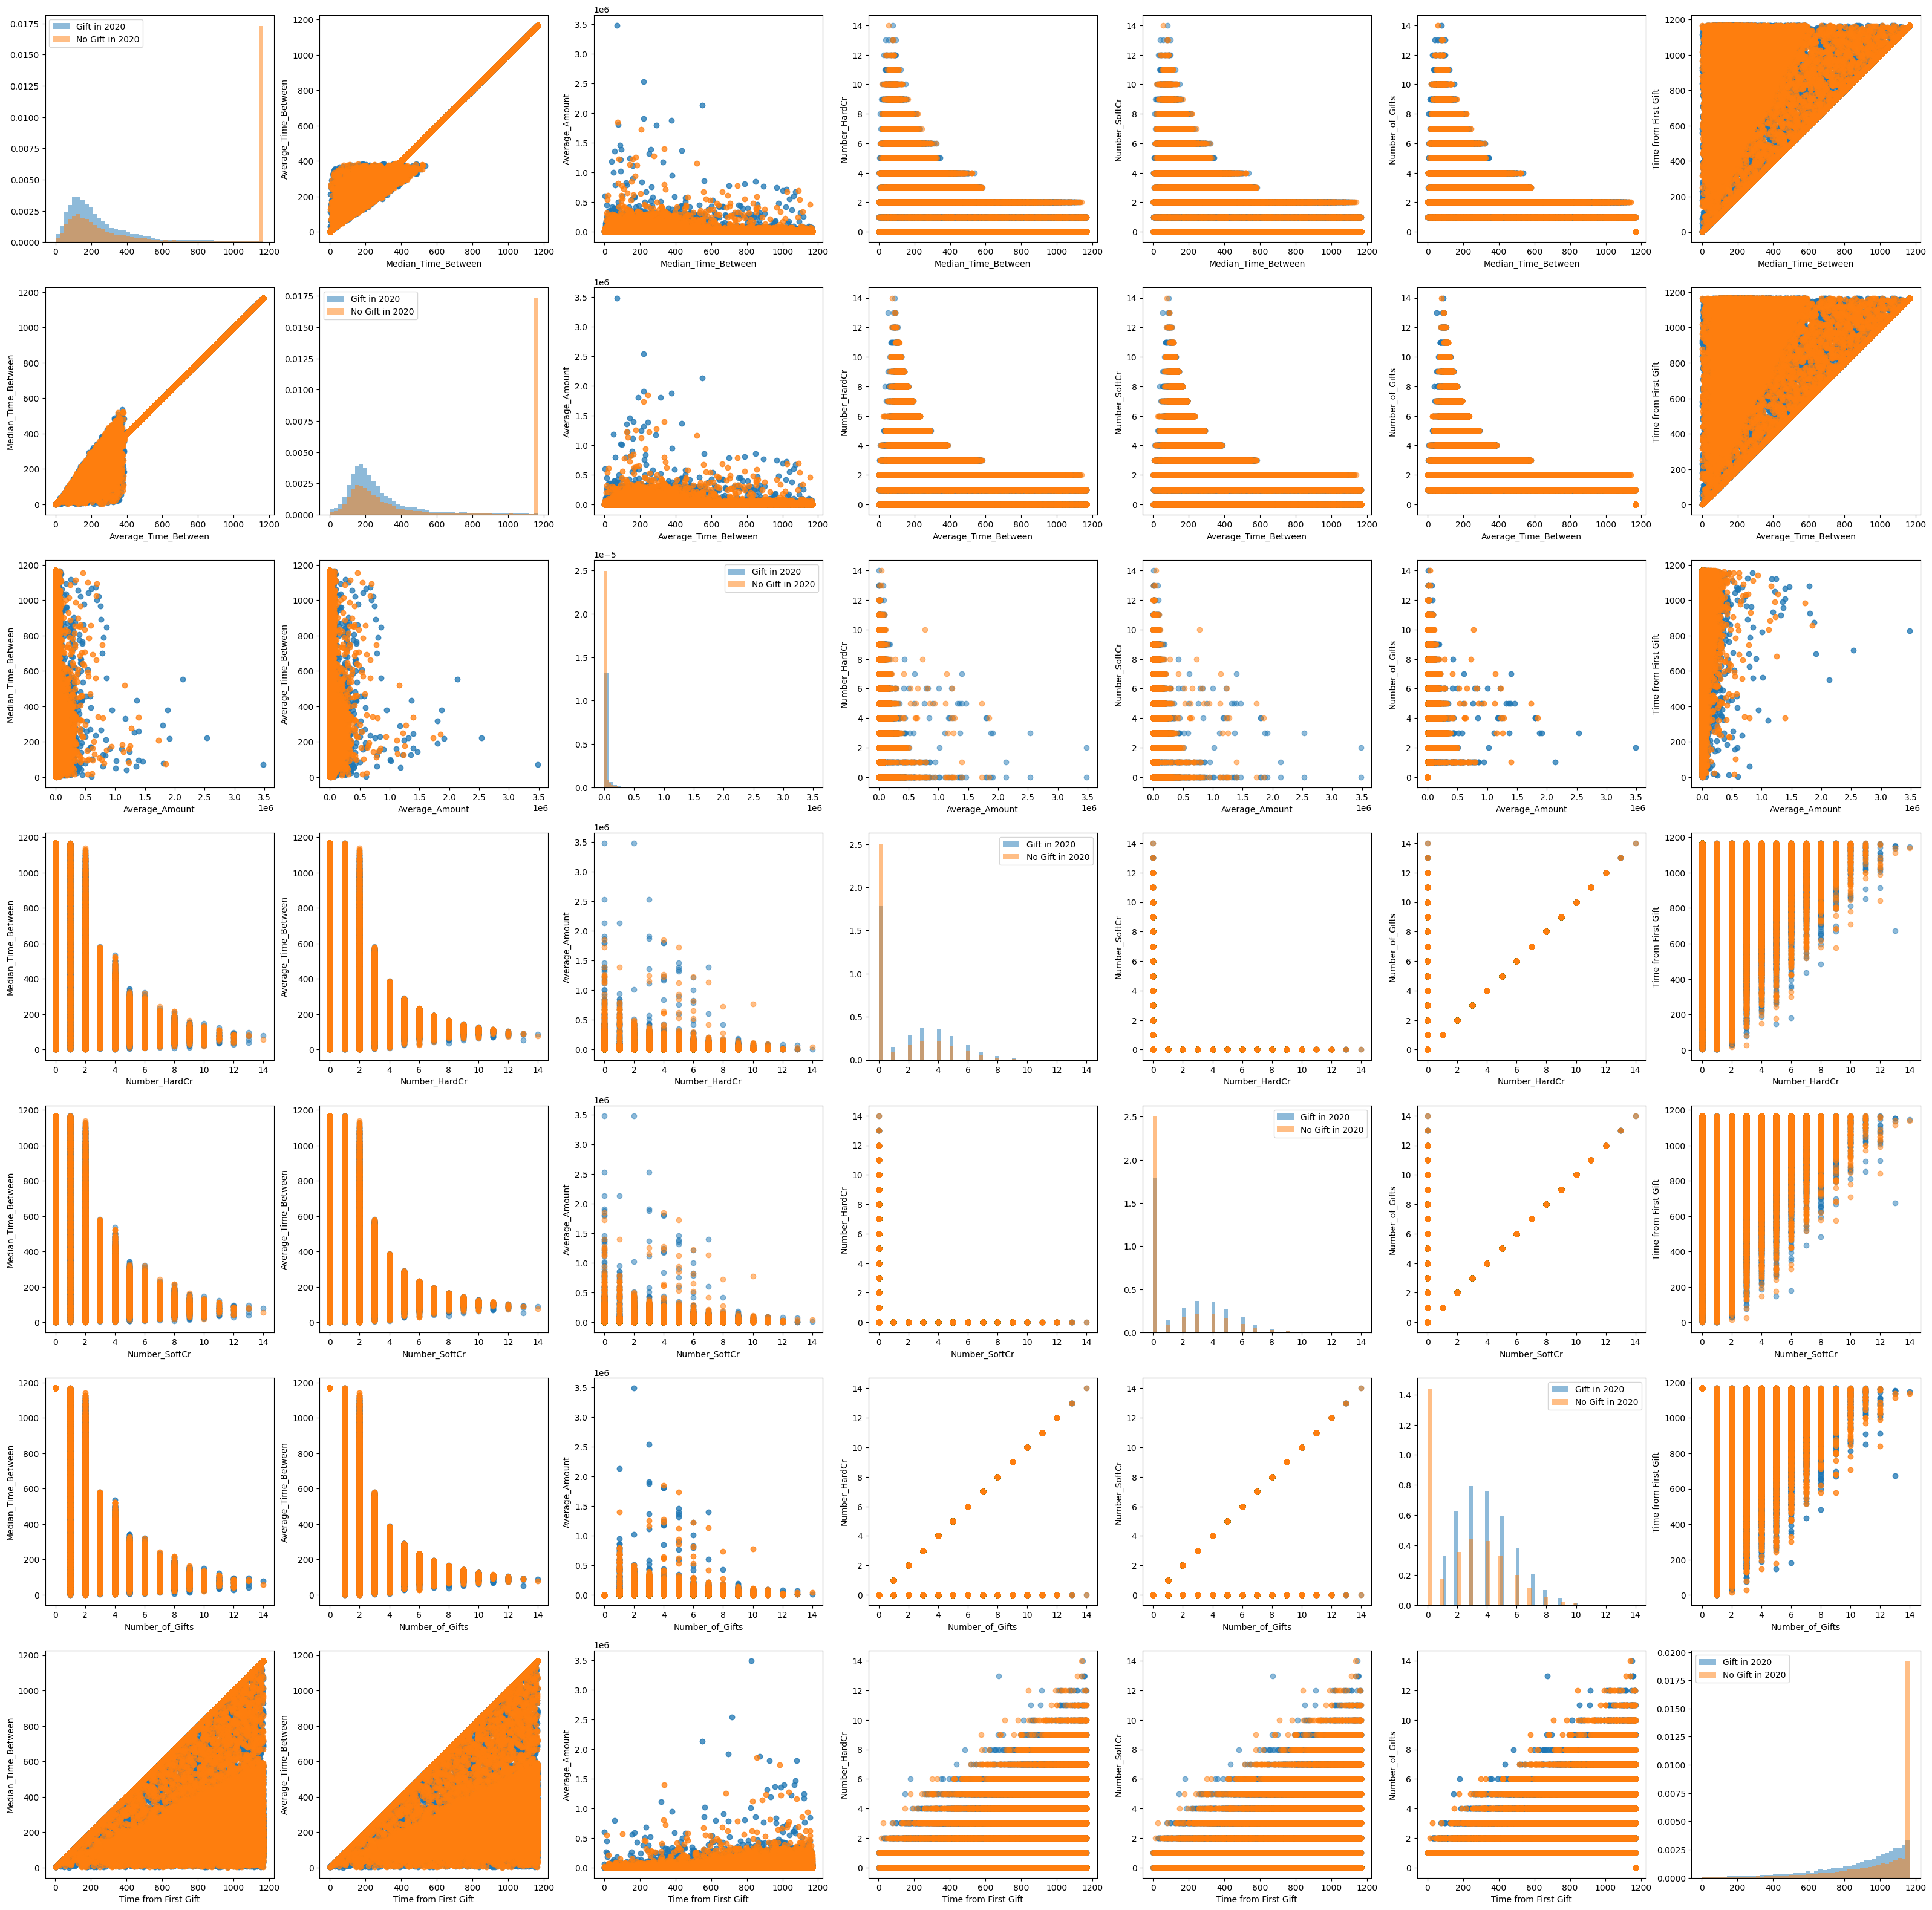

In [280]:
#Just gift columns
#Professor Farbin's pairplot code
#pair plots
selection_dict={'Gift in 2020':df_binary['Give in 2020?']==1,'No Gift in 2020':df_binary['Give in 2020?']==0} #label/naming and telling that 0/1 means background/signal respectively
column_names=['Median_Time_Between','Average_Time_Between','Average_Amount','Number_HardCr','Number_SoftCr','Number_of_Gifts','Time from First Gift']
n_columns=len(column_names)
plt.figure(figsize=(40,40)) #setting up figure size

plot_i=0 #counter to allow for indexing for placement of subplots

#iterating and enumerating through variables
for i,x_var_name in enumerate(column_names):
    #another loop since plotting each variable against each other
    for j,y_var_name in enumerate(column_names):
        plot_i+=1 #increase counter for indexing
        plt.subplot(n_columns,n_columns,plot_i) #subplot layout is the number of features by number of features; 'plot_it' is the index
        make_legend = plot_i==1
        if i==j: #plots on the diagonal
            #plot histogram of feature instead of scatterplot of one feature against itself
            compare_distributions(df_binary,x_var_name,
                     selection_dict,
                     alpha=0.5,
                     density=1,
                     bins=50,
                     )
        else:
            #when not on the diagonal, plot the scatter plot
            compare_scatter(df_binary,x_var_name,y_var_name,selection_dict,make_legend=make_legend,alpha=0.5)


Notes on Gift Info Columns
* All numerical columns
* Can see that those that gave Gifts in 2020 had a tighter distribution in Average and Median Time Between Gifts

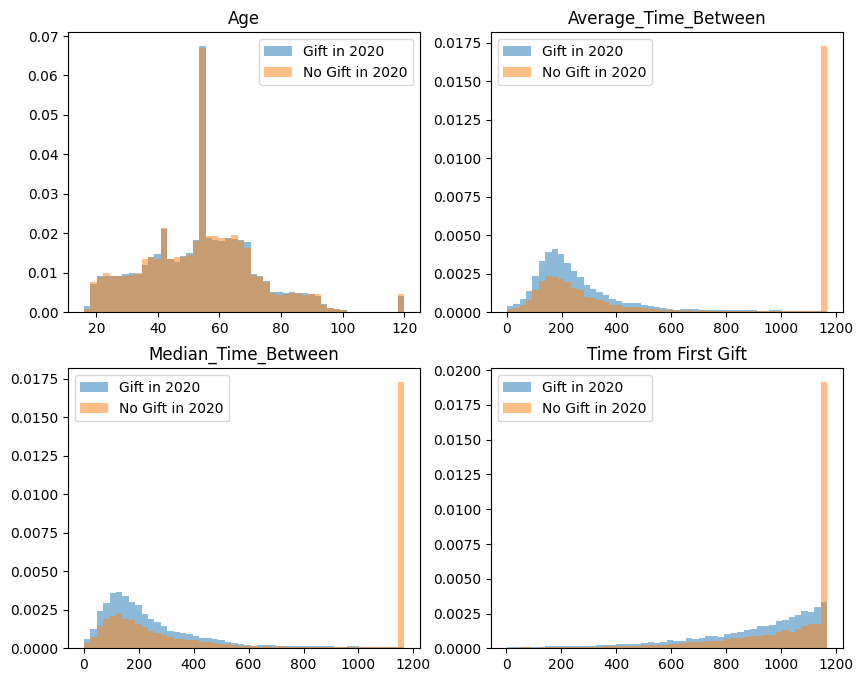

In [283]:
#Looking at only the numerical columns
variables=['Age','Average_Time_Between','Median_Time_Between','Time from First Gift']

count=1 #counter used for plotting boxplots

#figure size
plt.figure(figsize=(10,8))

#iterating through columns and plotting boxplot
for col in variables:
    plt.subplot(2,2,count)
    compare_distributions(df_binary,col,
                     selection_dict,
                     alpha=0.5,
                     density=1,
                     bins=50,
                     )
    plt.title(col)
    count+=1
plt.show()

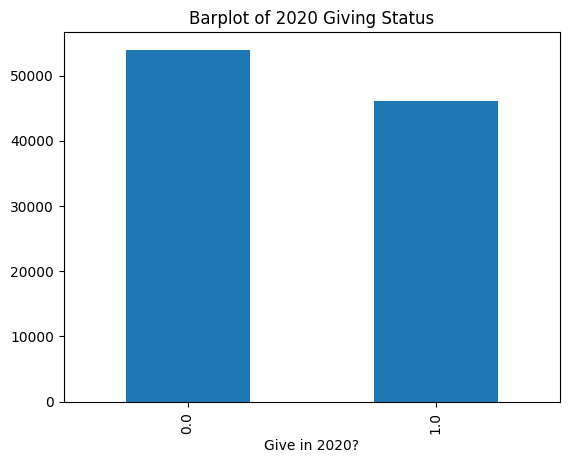

In [281]:
#looking at counts of Target Variable: Gift in 2020
df_binary['Give in 2020?'].value_counts().plot(kind='bar') # 1 = Gives in 2020; 0 = will not Give in 2020
plt.title('Barplot of 2020 Giving Status')
plt.show()

Distribution of target variable is fairly balances, was expecting there to be significantly less Giving in 2020 than those that did not Give in 2020

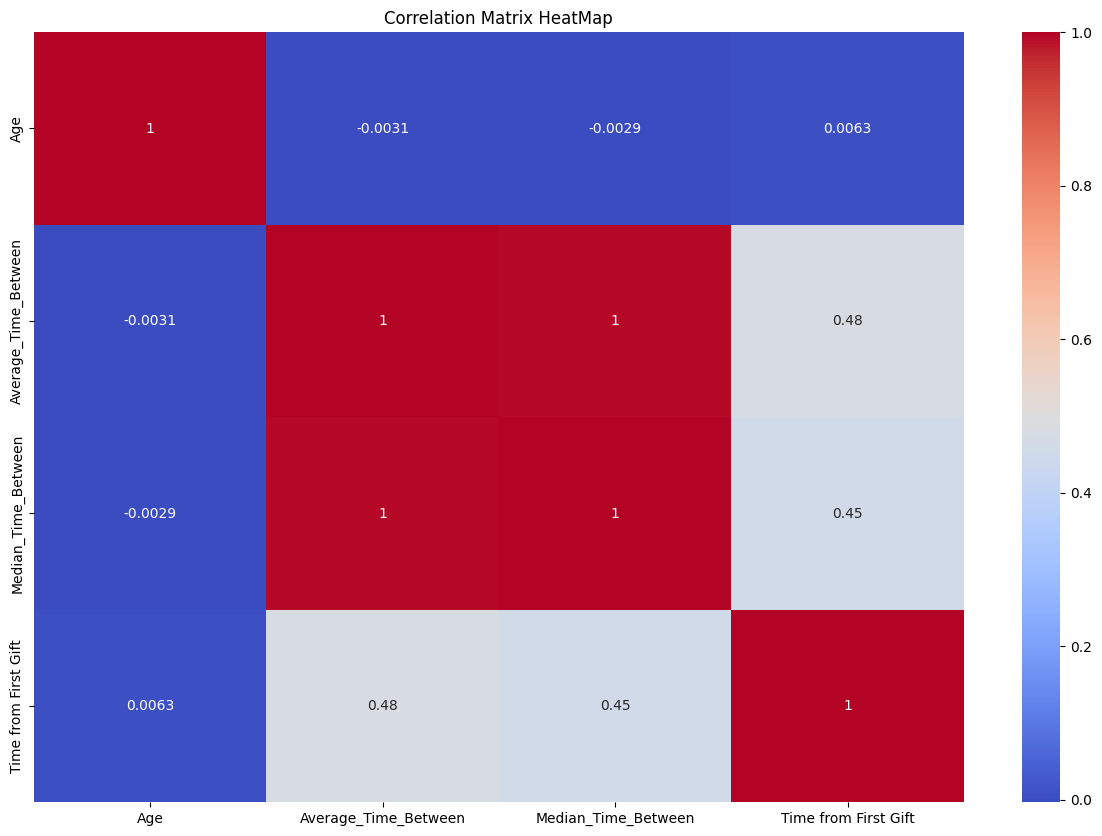

In [287]:
#Correlation
import seaborn as sns

corr_matrix=df_binary[variables].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix HeatMap')
plt.show()

Unsurprising that there is a significant correlation between Average and Median Time Between

# Data Cleaning
* Categorizing Age and further categorizing country
* One Hot Encode all categorical features
* Normalize numerical features
* df that is ready to be used to train ML models
    * Steps done in this section will be wrapped into 'Development_Preprocess.py' as a module to be used to quickly apply what was done in this notebook to the raw tables and create a prepared dataset

In [322]:
#categorizing Age
def age_group(a):
    if a<25:
        return 'Youth'
    elif a>=25 and a<35:
        return 'Young Adults'
    elif a>=35 and a<45:
        return 'Midlife Adults'
    elif a>=45 and a<55:
        return 'Established Adults'
    elif a>=55 and a<65:
        return 'Early Retirees/ Well-Established Adults'
    elif a>=65 and a>75:
        return 'Retirees'
    elif a>=75:
        return 'Elderly'

#applying function
df_binary['Age']=df_binary['Age'].apply(age_group)
df_binary.head()

country     city deceased      capacity capacity_source  \
0  United States   Agawam        N          >$1k       screening   
1  United States   Agawam        N  $75k - $100k       screening   
2  United States   Agawam        N  $75k - $100k       screening   
3  United States  Amherst        Y  $75k - $100k       screening   
4  United States  Amherst        N  $75k - $100k   institutional   

                 race                                      Age  \
0  Non-Hispanic white                                 Retirees   
1  Non-Hispanic white  Early Retirees/ Well-Established Adults   
2  Non-Hispanic white  Early Retirees/ Well-Established Adults   
3  Non-Hispanic white                                 Retirees   
4  Non-Hispanic white                           Midlife Adults   

   Birthday Month  Median_Time_Between  Average_Time_Between  Average_Amount  \
0             1.0               1167.0                1167.0             0.0   
1            10.0                132.0                 132.0           974.0   
2             3.0                132.0                 132.0           974.0   
3             7.0               1167.0                1167.0             0.0   
4             7.0               1167.0                1167.0             0.0   

   Number_HardCr  Number_SoftCr  Number_of_Gifts  Time from First Gift  \
0            0.0            0.0              0.0                1167.0   
1            2.0            0.0              2.0                 857.0   
2            0.0            2.0              2.0                 857.0   
3            0.0            0.0              0.0                1167.0   
4            0.0            0.0              0.0                1167.0   

   Give in 2020?  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [323]:
#unique values in 'country'
df_binary['country'].unique()

array(['United States', 'Bangladesh', 'Brazil', 'China', 'India',
       'Indonesia', 'Mexico', 'Nigeria', 'Pakistan', 'Russia'],
      dtype=object)

In [324]:
#from chatgpt
data = [
    {"Country": "United States", "Development": "Developed", "HDI": "Very High", "Income Group": "High income"},
    {"Country": "Bangladesh", "Development": "Developing", "HDI": "Medium", "Income Group": "Lower-middle income"},
    {"Country": "Brazil", "Development": "Emerging", "HDI": "High", "Income Group": "Upper-middle income"},
    {"Country": "China", "Development": "Emerging", "HDI": "High", "Income Group": "Upper-middle income"},
    {"Country": "India", "Development": "Developing", "HDI": "Medium", "Income Group": "Lower-middle income"},
    {"Country": "Indonesia", "Development": "Emerging", "HDI": "Medium", "Income Group": "Lower-middle income"},
    {"Country": "Mexico", "Development": "Emerging", "HDI": "High", "Income Group": "Upper-middle income"},
    {"Country": "Nigeria", "Development": "Developing", "HDI": "Low", "Income Group": "Lower-middle income"},
    {"Country": "Pakistan", "Development": "Developing", "HDI": "Low", "Income Group": "Lower-middle income"},
    {"Country": "Russia", "Development": "Emerging", "HDI": "High", "Income Group": "Upper-middle income"},
]
country_class=pd.DataFrame(data)
country_class

Country Development        HDI         Income Group
0  United States   Developed  Very High          High income
1     Bangladesh  Developing     Medium  Lower-middle income
2         Brazil    Emerging       High  Upper-middle income
3          China    Emerging       High  Upper-middle income
4          India  Developing     Medium  Lower-middle income
5      Indonesia    Emerging     Medium  Lower-middle income
6         Mexico    Emerging       High  Upper-middle income
7        Nigeria  Developing        Low  Lower-middle income
8       Pakistan  Developing        Low  Lower-middle income
9         Russia    Emerging       High  Upper-middle income

In [325]:
#All classifications offered result in the same division, so will use Development as grouping for Country
def country_class(c):
    if c=='United States':
        return 'Developed'
    elif c=='Bangladesh':
        return 'Developing'
    elif c=='Brazil':
        return 'Emerging'
    elif c=='China':
        return 'Emerging'
    elif c=='India':
        return 'Developing'
    elif c=='Indonesia':
        return 'Emerging'
    elif c=='Mexico':
        return 'Emerging'
    elif c=='Nigeria':
        return 'Developing'
    elif c=='Pakistan':
        return 'Developing'
    elif c=='Russia':
        return 'Emerging'
    
#applying function
df_binary['country']=df_binary['country'].apply(country_class)
df_binary.rename(columns={'country':'Country Class'},inplace=True)
df_binary.head()

Country Class     city deceased      capacity capacity_source  \
0     Developed   Agawam        N          >$1k       screening   
1     Developed   Agawam        N  $75k - $100k       screening   
2     Developed   Agawam        N  $75k - $100k       screening   
3     Developed  Amherst        Y  $75k - $100k       screening   
4     Developed  Amherst        N  $75k - $100k   institutional   

                 race                                      Age  \
0  Non-Hispanic white                                 Retirees   
1  Non-Hispanic white  Early Retirees/ Well-Established Adults   
2  Non-Hispanic white  Early Retirees/ Well-Established Adults   
3  Non-Hispanic white                                 Retirees   
4  Non-Hispanic white                           Midlife Adults   

   Birthday Month  Median_Time_Between  Average_Time_Between  Average_Amount  \
0             1.0               1167.0                1167.0             0.0   
1            10.0                132.0                 132.0           974.0   
2             3.0                132.0                 132.0           974.0   
3             7.0               1167.0                1167.0             0.0   
4             7.0               1167.0                1167.0             0.0   

   Number_HardCr  Number_SoftCr  Number_of_Gifts  Time from First Gift  \
0            0.0            0.0              0.0                1167.0   
1            2.0            0.0              2.0                 857.0   
2            0.0            2.0              2.0                 857.0   
3            0.0            0.0              0.0                1167.0   
4            0.0            0.0              0.0                1167.0   

   Give in 2020?  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [326]:
#dropping city; may come back to try classifying this over weekend
df_binary=df_binary.drop(columns=['city'],axis=1)
df_binary.head()

Country Class deceased      capacity capacity_source                race  \
0     Developed        N          >$1k       screening  Non-Hispanic white   
1     Developed        N  $75k - $100k       screening  Non-Hispanic white   
2     Developed        N  $75k - $100k       screening  Non-Hispanic white   
3     Developed        Y  $75k - $100k       screening  Non-Hispanic white   
4     Developed        N  $75k - $100k   institutional  Non-Hispanic white   

                                       Age  Birthday Month  \
0                                 Retirees             1.0   
1  Early Retirees/ Well-Established Adults            10.0   
2  Early Retirees/ Well-Established Adults             3.0   
3                                 Retirees             7.0   
4                           Midlife Adults             7.0   

   Median_Time_Between  Average_Time_Between  Average_Amount  Number_HardCr  \
0               1167.0                1167.0             0.0            0.0   
1                132.0                 132.0           974.0            2.0   
2                132.0                 132.0           974.0            0.0   
3               1167.0                1167.0             0.0            0.0   
4               1167.0                1167.0             0.0            0.0   

   Number_SoftCr  Number_of_Gifts  Time from First Gift  Give in 2020?  
0            0.0              0.0                1167.0            0.0  
1            0.0              2.0                 857.0            0.0  
2            2.0              2.0                 857.0            0.0  
3            0.0              0.0                1167.0            0.0  
4            0.0              0.0                1167.0            0.0

### Encoding/Normalization

In [289]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [328]:
#one hot encoding categorical columns
cat_varnames=['Country Class','deceased','capacity','capacity_source','race','Age','Birthday Month','Number_HardCr','Number_SoftCr','Number_of_Gifts']
encoder=OneHotEncoder()
encoder.fit(df_binary[cat_varnames])
encoded=pd.DataFrame(encoder.transform(df_binary[cat_varnames]).toarray())
encoded

0    1    2    3    4    5    6    7    8    9   ...   85   86   87  \
0      1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99995  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
99996  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
99997  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
99998  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0   
99999  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0   

        88   89   90   91   92   93   94  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
99995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[100000 rows x 95 columns]

In [330]:
#normalizing numerical columns
nums=df_binary.drop(columns=cat_varnames)
nums=nums.drop(columns='Give in 2020?') #also dropping target variable
scaler=MinMaxScaler()
nums=pd.DataFrame(scaler.fit_transform(nums),
                  columns=['Median_Time_Between','Average_Time_Between','Average_Amount','Time from First Gift'])
nums

Median_Time_Between  Average_Time_Between  Average_Amount  \
0                 1.000000              1.000000        0.000000   
1                 0.113111              0.113111        0.000280   
2                 0.113111              0.113111        0.000280   
3                 1.000000              1.000000        0.000000   
4                 1.000000              1.000000        0.000000   
...                    ...                   ...             ...   
99995             0.879177              0.879177        0.006782   
99996             0.007712              0.007712        0.002477   
99997             0.007712              0.007712        0.002477   
99998             0.193659              0.178021        0.000461   
99999             0.193659              0.178021        0.000461   

       Time from First Gift  
0                  1.000000  
1                  0.734134  
2                  0.734134  
3                  1.000000  
4                  1.000000  
...                     ...  
99995              0.982847  
99996              0.916810  
99997              0.916810  
99998              0.871355  
99999              0.871355  

[100000 rows x 4 columns]

In [332]:
#recombining numerical and categorical 
prepared_df=pd.concat([nums,encoded,df_binary['Give in 2020?']],axis=1)
prepared_df

Median_Time_Between  Average_Time_Between  Average_Amount  \
0                 1.000000              1.000000        0.000000   
1                 0.113111              0.113111        0.000280   
2                 0.113111              0.113111        0.000280   
3                 1.000000              1.000000        0.000000   
4                 1.000000              1.000000        0.000000   
...                    ...                   ...             ...   
99995             0.879177              0.879177        0.006782   
99996             0.007712              0.007712        0.002477   
99997             0.007712              0.007712        0.002477   
99998             0.193659              0.178021        0.000461   
99999             0.193659              0.178021        0.000461   

       Time from First Gift    0    1    2    3    4    5  ...   86   87   88  \
0                  1.000000  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
1                  0.734134  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
2                  0.734134  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
3                  1.000000  1.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
4                  1.000000  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99995              0.982847  0.0  0.0  1.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
99996              0.916810  0.0  0.0  1.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
99997              0.916810  0.0  0.0  1.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
99998              0.871355  0.0  0.0  1.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
99999              0.871355  0.0  0.0  1.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   

        89   90   91   92   93   94  Give in 2020?  
0      0.0  0.0  0.0  0.0  0.0  0.0            0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0            0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0            0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0            0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0            0.0  
...    ...  ...  ...  ...  ...  ...            ...  
99995  0.0  0.0  0.0  0.0  0.0  0.0            1.0  
99996  0.0  0.0  0.0  0.0  0.0  0.0            1.0  
99997  0.0  0.0  0.0  0.0  0.0  0.0            1.0  
99998  0.0  0.0  0.0  0.0  0.0  0.0            1.0  
99999  0.0  0.0  0.0  0.0  0.0  0.0            1.0  

[100000 rows x 100 columns]